# Analysis FAI

## Paquetes

In [3]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import re
import glob

## Functions

In [163]:

# mostrar un rango de datos de un TimeSeries
def show_range_ts(ts, start_idx, end_idx, height=300):
    df = ts.to_dataframe()
    subdf = df.iloc[start_idx:end_idx]
    display(HTML(f"""
    <div style="height:{height}px; overflow:auto; border:1px solid #ccc; padding:10px">
        {subdf.to_html()}
    </div>
    """))

# Uso:
#show_range_ts(goes_ts01, 0, 10)

#####################################
#     6. Calcula tiempos de FAI     #
#####################################

def calcular_fai_times(df, 
                       T_min=7, T_max=14, 
                       EM_threshold=0.005, 
                       col_T="T_cor", 
                       col_EM="EM_cor_norm"):
    """
    Calcula los tiempos en los que se cumplen los criterios del índice FAI.
    """

    # Copiar para no modificar el original
    df_fai = df.copy()

    # Condiciones del criterio FAI
    fai_condition = (
        (df_fai[col_T] >= T_min) & 
        (df_fai[col_T] <= T_max) & 
        (df_fai[col_EM] > EM_threshold)
    )

    # Selección
    df_fai_selected = df_fai[fai_condition]
    fai_times = df_fai_selected.index

    # Mostrar los resultados como en tu código original
    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")
    print(df_fai_selected[[col_T, col_EM]].head())

    return fai_times, df_fai_selected

######################
# 8. Graphs #
#######################

# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.

    Parameters:
    - df_combined: DataFrame with 'xrsa' and 'xrsb' columns and a DatetimeIndex.
    - df_fai_selected: DataFrame with temporal index for FAI events.
    - df_flare_data: DataFrame with 'event_peaktime' and 'Class' columns.
    - flare_start_time (str or pd.Timestamp): Start time of the plot interval.
    - flare_end_time (str or pd.Timestamp): End time of the plot interval.
    - ymin (float): Lower limit for y-axis (log scale).
    - ymax (float): Upper limit for y-axis (log scale).
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]


    plt.rcParams.update({
    "axes.titlesize": 16,     # título
    "axes.labelsize": 16,     # etiquetas de ejes
    "xtick.labelsize": 15,    # valores del eje X
    "ytick.labelsize": 15,    # valores del eje Y
    "legend.fontsize": 13     # texto de la leyenda
                        })
    # Create figure
    fig, ax = plt.subplots(figsize=(11, 4))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # X-axis ticks
    major_locator = mdates.MinuteLocator(byminute=range(0, 60, 10), interval=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 1)))
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()

    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

# Plot with Auto ticks for time axis
def plot_fai_and_flare_lines2(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # Auto ticks for time axis
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot T vs EM  con uno (coronal o fotosférico) o ambos modelos
def plot_T_vs_EM(df_full,
                 model="cor",   # "cor", "phot" or "both"
                 time_colors=None, 
                 title="", method_name="", integration_time="",
                 T_min=5, T_max=30, EM_min=1e46, EM_max=1e50,
                 temp_threshold=30, color_by_time=True,
                 start_time=None, end_time=None):
    """
    Plot Temperature vs Emission Measure (EM) from a DataFrame containing both models.

    Parameters
    ----------
    df_full : pandas.DataFrame
        DataFrame with columns ['T_cor','EM_cor','T_phot','EM_phot'].
    model : str, default="cor"
        Which model to plot: "cor" (coronal), "phot" (photospheric), or "both".
    time_colors : str or None
        Time limit to split colors (format 'YYYY-MM-DD HH:MM:SS').
    title : str
        Plot title.
    method_name : str
        Method label for the title.
    integration_time : str
        Integration time label for the title.
    T_min, T_max : float
        Limits for the temperature axis (MK).
    EM_min, EM_max : float
        Limits for the EM axis (cm⁻³, log scale).
    temp_threshold : float
        Maximum temperature (MK) to filter values.
    color_by_time : bool
        If True, color points by elapsed time (only applies to a single model).
    start_time, end_time : str or None
        Time interval to crop the DataFrame ('YYYY-MM-DD HH:MM:SS').

    Output
    ------
    None (shows a matplotlib plot).
    """

    # Crop DataFrame by time interval if specified
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df_full = df_full[df_full.index >= start_time]
    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df_full = df_full[df_full.index <= end_time]

    plt.figure(figsize=(6, 5))
    t0 = df_full.index[0]

    # ---- Coronal model ----
    if model in ["cor", "both"]:
        T_cor = df_full["T_cor"].to_numpy()
        EM_cor = df_full["EM_cor"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_cor = T_cor < temp_threshold
        T_cor, EM_cor, time_cor = T_cor[mask_cor], EM_cor[mask_cor], elapsed_time[mask_cor]

        if model == "cor" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_cor <= limit_seconds
            mask_gray = time_cor > limit_seconds

            sc = plt.scatter(EM_cor[mask_colored], T_cor[mask_colored],
                             c=time_cor[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_cor[mask_gray], T_cor[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_cor, T_cor, color="red", marker="o", s=12, label="Coronal")

    # ---- Photospheric model ----
    if model in ["phot", "both"]:
        T_phot = df_full["T_phot"].to_numpy()
        EM_phot = df_full["EM_phot"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_phot = T_phot < temp_threshold
        T_phot, EM_phot, time_phot = T_phot[mask_phot], EM_phot[mask_phot], elapsed_time[mask_phot]

        if model == "phot" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_phot <= limit_seconds
            mask_gray = time_phot > limit_seconds

            sc = plt.scatter(EM_phot[mask_colored], T_phot[mask_colored],
                             c=time_phot[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_phot[mask_gray], T_phot[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_phot, T_phot, color="blue", marker="^", s=12, label="Photospheric")

    # ---- Plot adjustments ----
    plt.xscale("log")
    plt.xlim(EM_min, EM_max)
    plt.ylim(T_min, T_max)
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(rf"{title} - {method_name}, Δt={integration_time}")
    if model == "both":
        plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


######################################
# 8. Tiempo de Anticipacion de flare #
######################################

def anticipation_fai_analysis(df_fai_selected, df_flare_data, 
                              peak_time_column="PeakTime",  
                              show_all=False, 
                              max_gap_fai=None,           # máxima anticipación permitida en minutos
                              max_gap_minutes=5,          # máxima separación entre FAIs para bloques
                              max_prev_flare_minutes=180,  # rango para calcular tiempo desde flare anterior en minutos
                              window_minutes=None          # nueva opción para ventana
                              ):
    """
    Calcula el tiempo de anticipación de cada flare a partir de FAIs previos,
    asegurando que no haya otro flare en medio y que la anticipación
    no exceda max_gap_fai si se define.

    Además, añade una columna con el tiempo en minutos desde el flare anterior
    más cercano, si este ocurre dentro de max_prev_flare_minutes.
    Incluye todas las columnas de df_fai_selected para el FAI asociado.

    Parámetros:
    - df_fai_selected: DataFrame con FAIs (índice temporal + todas las columnas)
    - df_flare_data: DataFrame con columna de tiempos de flares
    - peak_time_column: nombre de la columna de tiempo (ej. "PeakTime")
    - show_all: si False, elimina flares sin FAIs asociados
    - max_gap_minutes: separación máxima entre FAIs para formar bloques
    - max_gap_fai: máxima anticipación permitida en minutos
    - max_prev_flare_minutes: rango máximo en minutos para considerar flare anterior

    Retorna:
    - df_flare_data con columnas nuevas:
        - 'Anticipation (min)'
        - 'Previous FAI'
        - 'Time_since_prev_flare (min)'
      y todas las columnas de df_fai_selected correspondientes al FAI asociado.
    """
    df_flare_data = df_flare_data.copy()
    df_flare_data[peak_time_column] = pd.to_datetime(df_flare_data[peak_time_column])
    fai_times = pd.to_datetime(df_fai_selected.index).sort_values()
    df_flare_data = df_flare_data.sort_values(peak_time_column).reset_index(drop=True)

    anticipation_minutes = []
    used_fai = []
    time_since_prev_flare = []

    for i, peak_time in enumerate(df_flare_data[peak_time_column]):
        # 🔹 Calcular ventana válida para FAIs
        if i > 0:
            t_prev_flare = df_flare_data.loc[i-1, peak_time_column]
        else:
            t_prev_flare = pd.Timestamp.min

        valid_fais = fai_times[(fai_times > t_prev_flare) & (fai_times < peak_time)]

        # 🔹 Calcular anticipación a FAIs
        if not valid_fais.empty:
            diffs = valid_fais.to_series().diff().dt.total_seconds().div(60).fillna(0)
            group_ids = (diffs > max_gap_minutes).cumsum()
            last_group = group_ids.iloc[-1]
            group_fais = valid_fais[group_ids == last_group]

            earliest_fai = group_fais.min()
            anticipation = (peak_time - earliest_fai).total_seconds() / 60.0

            # Limitar anticipación máxima
            if max_gap_fai is not None:
                max_allowed_fai = peak_time - timedelta(minutes=max_gap_fai)
                if earliest_fai < max_allowed_fai:
                    earliest_fai = None
                    anticipation = None
        else:
            earliest_fai = None
            anticipation = None

        anticipation_minutes.append(anticipation)
        used_fai.append(earliest_fai)

        # 🔹 Calcular tiempo desde flare anterior dentro de rango
        if i > 0:
            prev_flare_time = df_flare_data.loc[i-1, peak_time_column]
            delta_min = (peak_time - prev_flare_time).total_seconds() / 60.0
            if delta_min <= max_prev_flare_minutes:
                time_since_prev_flare.append(delta_min)
            else:
                time_since_prev_flare.append(None)
        else:
            time_since_prev_flare.append(None)

    df_flare_data["Anticipation (min)"] = anticipation_minutes
    df_flare_data["Previous FAI"] = used_fai
    df_flare_data["Time_since_prev_flare (min)"] = time_since_prev_flare

    # 🔹 Adjuntar todas las columnas de df_fai_selected correspondientes al FAI usado
    if not df_flare_data.empty and not df_fai_selected.empty:
        df_flare_data = df_flare_data.merge(
            df_fai_selected, 
            how="left", 
            left_on="Previous FAI", 
            right_index=True,
            suffixes=("", "_FAI")
        )

    if not show_all:
        df_flare_data = df_flare_data[df_flare_data["Anticipation (min)"].notna()]

    return df_flare_data



# Revisa si hay un FAI en una ventana antes de cada flare
def check_fai_before_flare(fai_times, df_flare_data, flare_time_column="PeakTime", window_minutes=10):
    """
    
     Parámetros:
    - fai_times: lista/serie de timestamps de FAIs (indice (tiempo) de df_fai_selected -> tiempo que cumplen las condiciones FAI)
    - df_flare_data: DataFrame de flares
    - flare_time_column: nombre de la columna de tiempo del flare (ej. "PeakTime")
    - window_minutes: ventana para buscar flares

    Para cada flare, determina si hubo FAIs en los 'window_minutes' previos.
    Ajusta la ventana si hay un flare anterior, para que los FAIs
    no se asocien a más de un flare.

    Agrega columnas:
      - FAI_before_flare: bool (True si hubo al menos un FAI en la ventana)
      - FAI_first_time: primer FAI en la ventana
      - FAI_last_time: último FAI en la ventana
      - FAI_count: número total de FAIs en la ventana
    """
    results = df_flare_data.copy()
    results = results.sort_values(flare_time_column).reset_index(drop=True)

    results["FAI_before_flare"] = False
    results["FAI_first_time"] = pd.NaT
    results["FAI_last_time"] = pd.NaT
    results["FAI_count"] = 0

    for i, row in results.iterrows():
        flare_time = pd.to_datetime(row[flare_time_column])

        # Ventana inicial
        window_start = flare_time - pd.Timedelta(minutes=window_minutes)

        # Si hay un flare anterior y está dentro de la ventana → mover límite
        if i > 0:
            prev_flare_time = pd.to_datetime(results.loc[i-1, flare_time_column])
            if prev_flare_time > window_start:
                window_start = prev_flare_time

        window_end = flare_time

        # Buscar FAIs en la ventana ajustada
        fais_in_window = fai_times[(fai_times >= window_start) & (fai_times < window_end)]

        if len(fais_in_window) > 0:
            results.at[i, "FAI_before_flare"] = True
            results.at[i, "FAI_first_time"] = fais_in_window.min()
            results.at[i, "FAI_last_time"] = fais_in_window.max()
            results.at[i, "FAI_count"] = len(fais_in_window)

    return results


# agrupa por clases de flares en 2 grupos por clase
def assign_flare_group(flare_class):
    """
    Asigna un grupo a un flare según su clase y subnivel.
    
    Ejemplos:
    - C3.0 → C1-4
    - C7.5 → C5-9
    - X2.0 → X1-4
    - X7.0 → X5+
    """
    group_ranges = {
        "A": [(1, 4), (5, 9)],
        "B": [(1, 4), (5, 9)],
        "C": [(1, 4), (5, 9)],
        "M": [(1, 4), (5, 9)],
        "X": [(1, 4), (5, 1000)]  # 1000 actúa como "infinito"
    }

    try:
        letter = flare_class[0]  # A, B, C, M, X
        number = float(flare_class[1:])  # acepta decimales, ej: "2.7" → 2.7
    except:
        return flare_class  # si algo raro viene en el CSV

    if letter not in group_ranges:
        return flare_class

    for (low, high) in group_ranges[letter]:
        if low <= number <= high:
            if high >= 1000:  # caso abierto (ej: X5+)
                return f"{letter}{low}+"
            return f"{letter}{low}-{high}"
    
    return flare_class


#######
# csv #
#######
# Función definitiva (tamaño auto)
def plot_flare_summary_from_csv2(csv_fai_before, n_days, 
                                 window_minutes,
                                 group_subclasses=False,  # agrupar en 2 cada clase de flare True o False
                                 color_mode="palette:viridis"):  #  Elije el modo: "palette:<nombre>", "single:<color>", "by_class", "by_group" (si se activa group_subclasses=True)
                                                                 # cambiar paleta de colores palette:<nombre>:
                                                                 # "plasma", "cividis", "inferno", "magma", "tab10"
    """                     
    Lee un archivo CSV con columnas ["Class","FAI_before_flare"]
    y grafica el porcentaje de flares con FAI.
     Parámetro color_mode:
    - "palette:<nombre>" → usa paleta de Matplotlib (ej: "palette:viridis", "palette:tab10").
    - "single:<color>"   → usa un solo color (ej: "single:red", "single:#1f77b4").
    - "by_class"         → colores fijos por clase de flare (B, C, M, X)
    Parámetro group_subclasses:
    - False → usa las clases tal cual ("C9.0", "M2.5").
    - True  → agrupa en rangos:
              A/B/C/M: 1–4 y 5–9
              X: 1–4 y 5+.
    """
    """
    Lee un CSV de flares y grafica el % de FAI antes de flare por clase.
    """
   
    # -------------------------------
    # 1) Leer datos
    # -------------------------------
    df = pd.read_csv(csv_fai_before)

    # tolerancia en nombre de columna de FAI
    fai_col = None
    for cand in ["FAI_before_flare", "FAI_before", "FAI"]:
        if cand in df.columns:
            fai_col = cand
            break
    if "Class" not in df.columns or fai_col is None:
        raise ValueError("El CSV debe contener columnas 'Class' y 'FAI_before_flare' (o 'FAI_before'/'FAI').")

    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 actúa como "infinito"; se mostrará "X5+"
    }
    # -------------------------------
    # 2) Agrupación opcional por rangos
    # -------------------------------
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}-" + (f"{high}" if high<1000 else "+")
        return flare_class

    

    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(lambda x: assign_flare_group(str(x)))
    else:
        df["ClassGroup"] = df["Class"].astype(str).str[0]  # solo letra inicial

    # -------------------------------
    # 3) Cálculo de % y conteos
    # -------------------------------
    group_col = "ClassGroup"
    flare_summary = (df.groupby(group_col)[fai_col].mean() * 100).reset_index()
    flare_summary.rename(columns={fai_col: "FAI_percent"}, inplace=True)
    flare_counts = df.groupby(group_col)[fai_col].count()

    classes = flare_summary[group_col].tolist()
    values = flare_summary["FAI_percent"].tolist()
    n_bars = len(classes)

    # -------------------------------
    # 4) Colores
    # -------------------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # -------------------------------
    # 5) Tamaño dinámico + layout con eje extra para leyenda
    # -------------------------------
    # ancho crece con el número de barras para evitar amontonamiento
    chart_width = max(8, n_bars*1.2 )
    chart_height = 6

    fontsize = 8  # tamaño de letra
    item_width = 0.25 * fontsize  # relación empírica (0.25 in por punto de fuente)
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))

    # altura relativa de la "fila de leyenda": ~0.55 por fila (respecto a la parte alta que vale 6)
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 15,
    "legend.fontsize": 14
})

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=0.5) # posición leyenda debajo del gráfico

    

    # -------------------------------
    # 6) Eje principal (barras)
    # -------------------------------
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    

    # que las barras llenen el eje X
    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_xticks(range(n_bars))
    #ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_xticklabels(classes, rotation=0, ha="center")

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        if value < 100:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=14)

    # ejes/títulos
    ax.set_ylabel("FAI before flare (%)")
    ax.set_xlabel("Flare Class")
    ax.set_title(f"Percentage of flares with FAI before ({n_days} days) (window = {window_minutes} min)", 
                 pad=20) # espacio entre título y gráfica

    # -------------------------------
    # 7) Eje para la leyenda (debajo, sin solaparse jamás)
    # -------------------------------
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={flare_counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title="Number of flares per class:",
                  title_fontsize=15     # tamaño del título de la leyenda
                  )
    
    # Guardar figura en la carpeta Graphics
    output_name = f"{n_days}d_Flare_with_FAI_Window{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    

# Formato log en decimal normal
def log_decimal_format(x, pos):
    """Formato de tick: muestra 0.001, 0.01, 0.1, 1, 10, 100 sin notación científica"""
    if x >= 1:
        return f"{int(x)}"
    else:
        # Mostrar hasta 3 decimales, quitar ceros finales
        return f"{x:.3f}".rstrip("0").rstrip(".")


## prueba Leer CSV y graficar XRSA/EM y XRSB/T coloreando por clase de flare o por fecha
def plot_xrs_vs_te_from_csv2(days, 
                            csv_full ="call_df_full_100", 
                            csv_flares = "all_df_flare_data_100", 
                            time_column="PeakTime",
                            XRS="xrsa", T="T_cor", EM="EM_cor",
                            color_by=None,      # "Class" o "Date" u "Observatory"
                            palette="viridis",  
                            class_to_color=None # dict de colores fijos
                            ):
    """
    Lee datos de dos CSVs:
    - csv_full: contiene ['xrsa','xrsb','T_cor','EM_cor', ...] y un datetime index
    - csv_flares: contiene al menos la columna PeakTime
    
    Hace los gráficos:
      - XRS vs EM
      - XRS vs T
    Colores opcionales: por clase de flare o por fecha
    """

     # Leer CSV
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])

    xrs_vals, em_vals, t_vals, flare_labels = [], [], [], []

    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]
        if flare_time not in df_full.index:
            print(f"Flare en {flare_time} no encontrado en datos GOES, se salta.")
            continue

        flare_row = df_full.loc[flare_time]
        xrs_vals.append(flare_row[XRS])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare["Class"])[0])   # solo letra B,C,M,X
        elif color_by == "Date":
            flare_labels.append(flare_time.date())        # solo la fecha
        elif color_by == "Observatory":
            flare_labels.append(flare_row["observatory"]) # nombre del observatorio
        else:
            flare_labels.append("")

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Tamaños de letra
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"xrsb [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure for {days} days ({time_column})",
                      pad = 20) # espacio entre título y gráfico
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    # Limitar eje X desde 0.001 cm⁻³
    axes[0].set_xlim(0.001, None) # límite izquierdo en 0.001, derecho automático
    # Aplicar formatter personalizado al eje X
    axes[0].xaxis.set_major_formatter(FuncFormatter(log_decimal_format))

    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"xrsb [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature for {days} days ({time_column})",
                      pad= 20) #espacio entre título y gráfico
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    # Limitar eje X hasta 30 MK
    #axes[1].set_xlim(right=30)
    axes[1].set_xlim(0, 30)

    # --- Leyenda ajustada al ancho de los subplots ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left

        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        # Espacio inferior dinámico según filas
        bottom_space = 0.12 + 0.05 * (n_rows - 1)

        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.02),
                   ncol=ncol,
                   frameon=False,
                   title_fontsize=17)

        plt.subplots_adjust(bottom=bottom_space)

    # Guardar figura en la carpeta Graphics
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()



## basic xrsa vs em
def plot_xrsa_vs_em(csv_file, XRS="xrsa", EM="EM_cor"):
    """
    Lee un archivo CSV con columnas 'xrsa' y 'EM_cor'
    y grafica todos los puntos de XRS vs EM.
    """
    # Leer CSV
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # Gráfico
    plt.figure(figsize=(7,6))
    plt.scatter(df[EM], df[XRS], alpha=0.7, c="blue")

    plt.xscale("log")
    plt.yscale("log")

    # --- Cambiar formato de ejes a 10^n ---
    plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())
    plt.gca().yaxis.set_major_formatter(LogFormatterMathtext())

    plt.xlabel(EM)
    plt.ylabel(XRS)
    plt.title(f"{XRS} vs {EM} (todos los datos)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()


############################ 
## Total Flares with FAIs ##
############################

def plot_fai_association(csv_fai_before, n, fai_column="FAI_before_flare"):
    """
    Genera una gráfica de barras mostrando cuántos flares tienen FAIs asociados.
    con porcentaje dentro de la barra y número total encima.
    
    Parámetros:
    - csv_file: ruta del archivo CSV o un DataFrame.
    - fai_column: nombre de la columna que indica si hay FAI asociado (bool).
    """
    # Si recibimos un DataFrame en lugar de un CSV
    if isinstance(csv_fai_before, pd.DataFrame):
        df = csv_fai_before
    else:
        df = pd.read_csv(csv_fai_before)
    
    # Contar cuántos flares tienen FAI y cuántos no
    counts = df[fai_column].value_counts()
    total = counts.sum()
    
    # Reordenar para que True = With FAI aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)
    
    plt.rcParams.update({
    "axes.titlesize": 14,     # título
    "axes.labelsize": 14,     # etiquetas de ejes
    "xtick.labelsize": 14,    # valores del eje X
    "ytick.labelsize": 14,    # valores del eje Y
    "legend.fontsize": 14     # texto de la leyenda
                        })

     # Crear la gráfica
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['With FAI', 'Without FAI'])
    ax.set_ylabel("Percentage of Flares (%)")
    ax.set_title(f"Flares with Associated FAIs ({n} days, Window ={window_minutes}min)",
                 pad=20) # espacio entre título y gráfico
    
    # Agregar porcentaje dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black")
    
    # Agregar número total arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', 
                    fontsize=14, color="black")
    
    # --- Leyenda con total de flares en esquina superior derecha ---
    ax.text(0.95, 0.95, f"Total Flares = {total}",
            transform=ax.transAxes,  # coordenadas relativas al eje
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura en la carpeta Graphics
    output_name = f"{n}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

###################################################
### calculo de FAIs que están asociados a Flares ##
###################################################

def associate_fai_to_flare(csv_fai_selected, csv_flares, window_minutes=30, time_ref='PeakTime'):
    """
    Asocia cada alerta FAI a un flare que ocurra dentro de una ventana hacia adelante.

    Parameters:
    - csv_fai_selected: path al CSV con alertas FAI (índice o columna Unnamed:0 = fecha/hora)
    - csv_flares: path al CSV con flares
    - window_minutes: ventana de búsqueda en minutos (hacia adelante desde la FAI)
    - time_ref: 'PeakTime' o 'StartTime', qué hora del flare usar para medir distancia

    Returns:
    - df_fai: DataFrame de FAIs con columnas adicionales sobre el flare asociado
    """
    # Leer los CSV
    df_fai = pd.read_csv(csv_fai_selected)
    df_flares = pd.read_csv(csv_flares)

    # La columna de tiempo está en "Unnamed: 0"
    df_fai['Time_FAI'] = pd.to_datetime(df_fai['Unnamed: 0'])

    # Asegurar formato datetime en flares
    df_flares['StartTime'] = pd.to_datetime(df_flares['StartTime'])
    df_flares['EndTime'] = pd.to_datetime(df_flares['EndTime'])
    df_flares['PeakTime'] = pd.to_datetime(df_flares['PeakTime'])

    # Inicializar columnas
    df_fai['Associated_Flare'] = False
    df_fai['Flare_StartTime'] = pd.NaT
    df_fai['Flare_EndTime'] = pd.NaT
    df_fai['Flare_PeakTime'] = pd.NaT
    df_fai['Flare_Class'] = None
    df_fai['Time_to_flare'] = None

    window = pd.Timedelta(minutes=window_minutes)

    for idx, row in df_fai.iterrows():
        fai_time = row['Time_FAI']

        # Flares dentro de la ventana hacia adelante
        mask = (df_flares[time_ref] >= fai_time) & (df_flares[time_ref] <= fai_time + window)
        candidate_flares = df_flares[mask].sort_values(time_ref)

        if not candidate_flares.empty:
            flare = candidate_flares.iloc[0]  # Tomamos el primero
            df_fai.at[idx, 'Associated_Flare'] = True
            df_fai.at[idx, 'Flare_StartTime'] = flare['StartTime']
            df_fai.at[idx, 'Flare_EndTime'] = flare['EndTime']
            df_fai.at[idx, 'Flare_PeakTime'] = flare['PeakTime']
            df_fai.at[idx, 'Flare_Class'] = flare['Class']
            df_fai.at[idx, 'Time_to_flare'] = (flare[time_ref] - fai_time).total_seconds() / 60  # minutos

    return df_fai

####################################################
### FAI Alerts Associated with Flares - 2 columnas##
####################################################

def plot_fai_association_summary(csv_fai_assoc, window, column="Associated_Flare"):
    """
    Reads a CSV with FAIs and generates a bar plot showing the percentage of FAIs
    that are associated with flares (True) and not associated (False).

    Parameters
    ----------
    csv_fai_assoc : str
        Path to the CSV file containing FAIs (must include column 'Associated_Flare').
    window_minutes : int
        Time window (minutes) used to define association (for title context).
    column : str, default="Associated_Flare"
        Column name with True/False values.
    """
    # Read the CSV
    df_fai = pd.read_csv(csv_fai_assoc)

    # Count True (associated) vs False (not associated)
    counts = df_fai[column].value_counts()
    total = counts.sum()

    # Reorder so True = Associated appears first
    counts = counts.reindex([True, False])

    # Percentages
    percentages = (counts / total * 100).round(1)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Associated', 'Not Associated'])
    ax.set_ylabel("Percentage of FAIs (%)")
    ax.set_title(f"FAI Alerts Associated with Flares ({n} days, Window = {window} min)",
                 pad=20) # espacio entre título y gráfico

    # Add percentages inside bars
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', fontsize=15, color="black")

    # Add absolute counts above bars
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', fontsize=15, color="black")

    # --- Recuadro con total de alertas FAI dentro del gráfico ---
    ax.text(0.95, 0.95, f"Total FAI Alerts = {total}",
            transform=ax.transAxes,  # coordenadas relativas al eje
            ha='right', va='top',
            fontsize=13,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura en la carpeta Graphics
    output_name = f"{n}d_FAI_associated_Flares_Window{window}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


### barras fais asosciados a flares por clase o no asociados 

# Generates a bar chart showing the distribution of FAIs (Flare Alert Indicators) as percentages.
def plot_fai_distribution(csv_fai_assoc,
                          window,
                          class_col="Flare_Class",
                          assoc_col="Associated_Flare",
                          group_subclasses=False,
                          color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages:
    - Fraction of FAIs associated with each flare class (or subrange if group_subclasses=True)
    - Fraction not associated with any flare ("No flare")
    
    Parameters:
    - csv_fai_assoc: CSV file with at least columns `class_col` and `assoc_col`
    - window: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = pd.read_csv(csv_fai_assoc)

    if class_col not in df.columns or assoc_col not in df.columns:
        raise ValueError(f"CSV must contain '{class_col}' and '{assoc_col}'.")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]

    # Etiquetar FAIs no asociados
    df["AssocGroup"] = df.apply(
        lambda row: row["ClassGroup"] if row[assoc_col] else "No flare", axis=1
    )

    # Contar distribución
    counts = df["AssocGroup"].value_counts()

    # Ordenar clases: primero A, B, C, M, X o sus subrangos, luego "No flare"
    if group_subclasses:
        flare_classes = sorted([c for c in counts.index if c != "No flare"])
    else:
        flare_classes_order = ["A", "B", "C", "M", "X"]
        flare_classes = [cls for cls in flare_classes_order if cls in counts.index]

    if "No flare" in counts.index:
        flare_classes.append("No flare")

    counts_ordered = counts[flare_classes]
    percentages = (counts_ordered / counts_ordered.sum()) * 100

    classes = percentages.index.tolist()
    values = percentages.tolist()
    n_bars = len(classes)

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato",
                       "No flare": "gray"}
        colors = [base_colors.get(str(c)[0], base_colors.get(c, "gray")) for c in classes]
    else:
        colors = "skyblue"

    # --- Layout con leyenda abajo ---
    chart_width = max(8, n_bars *1.3 )
    chart_height = 6.7

    fontsize = 10
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    

    # --- Subplots ---
    plt.rcParams.update({
    "axes.titlesize": 17,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 15,
    "legend.fontsize": 14
})
    

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=0.5) # espacio entre gráfico y leyenda
    # --- Gráfico de barras ---
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_ylim(0, max(values) * 1.1)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=0, ha="center")
    ax.set_ylabel("FAIs (% of total)")
    ax.set_xlabel("Flare Class (or No flare)")
    ax.set_title(f"Distribution of FAIs: Associated vs Not Associated ({n} days, Window = {window} min)",
                 pad=20) # espacio entre título y gráfico

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=15)

    # --- Leyenda abajo ---
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts_ordered[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title_fontsize=16, # tamaño titulo leyenda
                  title="Number of FAIs per group:")

    output_name = f"{n}d_Distribution_FAIs_All_Window{window}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##### barras fais asosciados a flares por clase ( sin no asociados )
# Generates a bar plot of how many FAIs are associated with each flare class.
def plot_fai_by_flare_class(csv_fai_assoc, window, flare_class_col="Flare_Class", assoc_col="Associated_Flare",
                            group_mode="letter", color_mode="palette:viridis"):
    """
    Generates a bar plot of how many FAIs are associated with each flare class.

    Parameters:
    - csv_fai_assoc: path to the CSV file containing FAIs
    - flare_class_col: column name for flare class (default: 'Flare_Class')
    - assoc_col: column name indicating if the FAI is associated (default: 'Associated_Flare')
    - group_mode: how to group flare classes:
        "exact"  -> show each exact class (C1.2, M3.5, ...)
        "letter" -> group only by letter (C, M, X, ...)
        "range"  -> group by predefined ranges per letter
    - color_mode: choose color scheme
        "palette:<name>" → Matplotlib palette (viridis, plasma, tab10, etc.)
        "single:<color>" → one single color (e.g., "single:red")
        "by_class"       → fixed colors by flare class letter
    """

    # Default group ranges (used when group_mode="range")
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 = infinito → X5+
    }

    # Read the CSV
    df_fai = pd.read_csv(csv_fai_assoc)

    # Filter only FAIs associated with a flare
    df_assoc = df_fai[df_fai[assoc_col] == True].copy()

    # -----------------------
    # Group by mode
    # -----------------------
    if group_mode == "exact":
        counts = df_assoc[flare_class_col].value_counts().sort_index()
        classes = counts.index.tolist()

    elif group_mode == "letter":
        df_assoc["Class_Group"] = df_assoc[flare_class_col].astype(str).str[0]
        counts = df_assoc["Class_Group"].value_counts().reindex(["A","B","C","M","X"]).dropna()
        classes = counts.index.tolist()

    elif group_mode == "range":
        # Extract letter and numeric part
        df_assoc["Class_Letter"] = df_assoc[flare_class_col].astype(str).str[0]
        df_assoc["Class_Value"] = df_assoc[flare_class_col].astype(str).str[1:].astype(float)

        def assign_range(row):
            letter = row["Class_Letter"]
            value = row["Class_Value"]
            if letter in group_ranges:
                for low, high in group_ranges[letter]:
                    if low <= value <= high:
                        if high >= 1000:  # open-ended (e.g. X5+)
                            return f"{letter}{low}+"
                        else:
                            return f"{letter}{low}-{high}"
            return None

        df_assoc["Range_Group"] = df_assoc.apply(assign_range, axis=1)
        counts = df_assoc["Range_Group"].value_counts().sort_index()
        classes = counts.index.tolist()

    else:
        raise ValueError("Invalid group_mode. Use 'exact', 'letter', or 'range'.")

    n_bars = len(classes)

    # -----------------------
    # Colors
    # -----------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # -----------------------
    # Plot
    # -----------------------
    plt.figure(figsize=(max(8, n_bars*0.6), 5))
    bars = plt.bar(range(n_bars), counts.values, color=colors, width=0.9)

    #plt.xticks(range(n_bars), classes, rotation=45, ha="right")
    plt.xticks(range(n_bars), classes, rotation=0, ha="center")
    plt.ylabel("Number of Associated FAIs")
    plt.xlabel("Flare Class")
    plt.title(f"FAIs Associated with Flare Classes ({n} days, window = {window} min)")

    # Add counts on top of bars
    for bar, v in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, v + 0.5, str(int(v)),
                 ha='center', va='bottom', fontsize=9, fontweight="bold")
    
    output_name = f"{n}d_Distribution_FAIs_Window{window}min_GroupClass{group_mode}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

##################################################
#### Gráfica tiempos de anticipación vs T y EM ###
##################################################

def plot_anticipation_vs_te(days,
                            max_gap_fai,
                            csv_full="call_df_full_100.csv",
                            csv_flares="all_df_flare_data_100.csv",
                            csv_anticipation="anticipation_time.csv",
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor",
                            color_by=None,        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None  # dict de colores fijos
                            ):
    """
    Grafica:
      - T vs tiempo de anticipación
      - EM vs tiempo de anticipación
    usando el archivo anticipation_time.
    """

    # --- Leer CSVs ---
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])
    df_anticipation = pd.read_csv(csv_anticipation, parse_dates=[time_column])

    anticipation_vals, t_vals, em_vals, flare_labels = [], [], [], []

    # Recorremos cada flare
    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]

        # Buscar anticipación en el CSV correspondiente
        row_ant = df_anticipation[df_anticipation[time_column] == flare_time]
        if row_ant.empty:
            continue

        delta_minutes = row_ant["Anticipation (min)"].values[0]

        if flare_time not in df_full.index:
            continue
        flare_row = df_full.loc[flare_time]

        anticipation_vals.append(delta_minutes)
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare["Class"])[0])   # letra de clase
        elif color_by == "Date":
            flare_labels.append(flare_time.date())
        elif color_by == "Observatory":
            flare_labels.append(flare_row["observatory"])
        else:
            flare_labels.append("")

    # --- Colores ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # --- Subplots ---
    plt.rcParams.update({
    "axes.titlesize": 15,
    "axes.labelsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 10 })
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # T vs Anticipación
    axes[0].scatter(t_vals, anticipation_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(f"T [MK]")
    axes[0].set_xlim(0, 30)   # T en el rango de 0 a 30 MK
    axes[0].set_ylabel("Anticipation Time [min]")
    axes[0].set_title(f"Temperature vs Anticipation ({days} days, Window={max_gap_fai} min)")
    axes[0].set_yscale("log")   # <- Escala log en Y

    # EM vs Anticipación
    axes[1].scatter(em_vals, anticipation_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(rf"EM [cm$^{{-3}}$]")
    axes[1].set_ylabel("Anticipation Time [min]")
    axes[1].set_title(f"Emission Measure vs Anticipation for ({days} days,  Window={max_gap_fai} min)")
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")   # Y en log

    # --- Formato personalizado para logs ---
    def log_format(x, pos):
        # Si es un entero, mostrarlo sin decimales
        if x >= 1:
            return f"{int(x)}"
        else:
            # Para los menores de 1, mostrar en notación decimal normal
            return f"{x:.3f}".rstrip("0").rstrip(".")

    formatter = FuncFormatter(log_format)

    for ax in axes:
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        

    # --- Leyenda ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.02),
                   ncol=min(len(labels), 6),
                   frameon=False,
                   fontsize=8)
    
    output_name = f"{days}d_AnticipatioTime_vs_T_EM_Window{max_gap_fai}min_Color{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##

## FAI Function

In [5]:

def fai_from_csv(output_dir, n,
                 fai_temp_range=(7, 14), 
                 fai_em_threshold=0.005, 
                 peak_time_column="PeakTime", 
                 max_gap_fai =None,
                 max_gap_minutes=5,
                 window_minutes=10,
                 show_all=False,
                 max_prev_flare_minutes=180):
    """
    Calcula el FAI y la anticipación a partir de archivos CSV consolidados
    generados previamente por bloques.

    Parámetros:
    -----------
    output_dir : str
        Carpeta donde están los CSV consolidados.
    n : int
        Número de días analizados (para construir nombre del archivo CSV).
    fai_temp_range : tuple, opcional
        Rango de temperatura coronal para criterio FAI (default (7, 14)).
    fai_em_threshold : float, opcional
        Umbral mínimo de EM_cor_norm para criterio FAI (default 0.005).
    peak_time_column : str, opcional
        Columna en df_flare_data que indica el tiempo pico del flare.
    max_gap_minutes : int, opcional
        Máxima separación entre FAIs en minutos para formar bloques.
    window_minutes : int, opcional
        Ventana de tiempo antes del flare para determinar si hay FAI.
    show_all : bool, opcional
        Si True, muestra todos los resultados de anticipación.

    Retorna:
    --------
    dict con:
        - df_full : DataFrame consolidado con todos los cálculos
        - df_fai_selected : DataFrame con los puntos que cumplen criterio FAI
        - fai_times : Índices (tiempos) seleccionados por criterio FAI
        - df_flare_data : DataFrame de flares
        - anticipation_time : Resultados de anticipación
        - df_flare_fai_before : Relación entre FAIs y flares
    """

    # Leer CSVs consolidados
    df_full_file = os.path.join(output_dir, f"all_df_full_{n}.csv")
    df_flare_file = os.path.join(output_dir, f"all_df_flare_data_{n}.csv")

    if not os.path.exists(df_full_file):
        raise FileNotFoundError(f"No se encontró {df_full_file}")
    if not os.path.exists(df_flare_file):
        print(f"No se encontró {df_flare_file}. Se continuará con df_flare_data vacío.")
        df_flare_data = pd.DataFrame()
    else:
        df_flare_data = pd.read_csv(df_flare_file, parse_dates=["StartTime","PeakTime","EndTime"])

    df_full = pd.read_csv(df_full_file, index_col=0, parse_dates=True)

    # Calcular FAI times según criterios
    fai_condition = (
        (df_full['T_cor'] >= fai_temp_range[0]) &
        (df_full['T_cor'] <= fai_temp_range[1]) &
        (df_full['EM_cor_norm'] > fai_em_threshold)
    )
    df_fai_selected = df_full[fai_condition]
    fai_times = df_fai_selected.index

    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")

    # Calcular anticipación
    if df_flare_data.empty:
        anticipation_time = pd.DataFrame()
        df_flare_fai_before = pd.DataFrame()
    else:
        anticipation_time = anticipation_fai_analysis(df_fai_selected=df_fai_selected, 
                                                      df_flare_data=df_flare_data, 
                                                        peak_time_column=peak_time_column,  
                                                        show_all=show_all, 
                                                        max_gap_fai=max_gap_fai,  # máxima anticipación permitida en minutos
                                                        max_gap_minutes=max_gap_minutes, # máxima separación entre FAIs para bloques
                                                        max_prev_flare_minutes=max_prev_flare_minutes  # rango para calcular tiempo desde flare anterior en minutos
                                                        )
        

        df_flare_fai_before = check_fai_before_flare(fai_times=fai_times,
                                                    df_flare_data=df_flare_data,
                                                    flare_time_column=peak_time_column,
                                                    window_minutes=window_minutes
                                                    )

    return {
        "df_full": df_full,
        "df_fai_selected": df_fai_selected,
        "fai_times": fai_times,
        "df_flare_data": df_flare_data,
        "anticipation_time": anticipation_time,
        "df_flare_fai_before": df_flare_fai_before
    }

## Parámetros # días y fecha de la carpetandodne están los datos

In [6]:
n=200
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-09-18"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days"

## New folder for data

In [7]:
results = fai_from_csv(output_dir, n=n,
                 fai_temp_range=(7, 14), 
                 fai_em_threshold=0.005, 
                 peak_time_column="PeakTime", 
                 max_gap_fai =window_minutes, # tiempo máximo de FAI (en min)
                 max_gap_minutes=0,
                 window_minutes=window_minutes,
                 show_all=False,
                 max_prev_flare_minutes=60)

df_full = results["df_full"]
df_fai_selected = results["df_fai_selected"]
fai_times = results["fai_times"]
df_flare_data = results["df_flare_data"]
anticipation_time = results["anticipation_time"]
df_flare_fai_before = results["df_flare_fai_before"]

Se encontraron 16161 puntos que cumplen el criterio FAI.



In [8]:
# Crear subcarpeta para guardar resultados de análisis
analysis_dir = os.path.join(output_dir, "Analysis")
os.makedirs(analysis_dir, exist_ok=True)
print(f"Carpeta de análisis creada: {analysis_dir}")

# Guardar DataFrames resultantes
df_full.to_csv(os.path.join(analysis_dir, "df_full.csv"))
df_fai_selected.to_csv(os.path.join(analysis_dir, "df_fai_selected.csv"))
df_flare_data.to_csv(os.path.join(analysis_dir, "df_flare_data.csv"))
anticipation_time.to_csv(os.path.join(analysis_dir, "anticipation_time.csv"))
df_flare_fai_before.to_csv(os.path.join(analysis_dir, "df_flare_fai_before.csv"))

print("✅ Todos los análisis guardados correctamente.")

Carpeta de análisis creada: 2025-09-18_Analysis_for_200_days/Analysis
✅ Todos los análisis guardados correctamente.


## Filtrar datos negativos

In [9]:
# df_full es el DataFrame final
flux_cols = ['xrsa_corr', 'xrsb_corr']  # columnas de flujos a filtrar

# Contar cuantas filas hay en total
print(f"Hay {len(df_full)} registros en total")

# Contar cuántos datos negativos hay
neg_count = (df_full[flux_cols] <= 0).sum().sum()
print(f"⚠ Se eliminarán {neg_count} registros con flujo negativo.")

neg_rows = (df_full[flux_cols] <= 0).any(axis=1).sum()
print(f"⚠ Se eliminarán {neg_rows} filas con flujo negativo.")

# Filtrar solo los positivos
df_full_filtered = df_full[(df_full['xrsa_corr'] > 0) & (df_full['xrsb_corr'] > 0)]

print(f"✅ Después del filtrado, quedan {len(df_full_filtered)} registros válidos.")

print(len(df_full_filtered) + neg_rows)
# Guardar df_full filtrado como CSV
filtered_file = os.path.join(analysis_dir, "df_full_filtered.csv")
df_full_filtered.to_csv(filtered_file)

print(f"✅ DataFrame filtrado guardado en: {filtered_file}")


Hay 226878 registros en total
⚠ Se eliminarán 268360 registros con flujo negativo.
⚠ Se eliminarán 162547 filas con flujo negativo.
✅ Después del filtrado, quedan 60728 registros válidos.
223275
✅ DataFrame filtrado guardado en: 2025-09-18_Analysis_for_200_days/Analysis/df_full_filtered.csv


In [10]:
nan_rows = df_full[flux_cols].isna().any(axis=1).sum()
print(f"⚠ Se eliminarán {nan_rows} filas con NaN en las columnas de flujo.")

print(f"Check: {len(df_full_filtered) + neg_rows + nan_rows} == {len(df_full)}")

⚠ Se eliminarán 3603 filas con NaN en las columnas de flujo.
Check: 226878 == 226878


In [11]:
print(df_full_filtered)

                    observatory          xrsa      xrsb     xrsa_corr  \
Unnamed: 0                                                              
1980-01-05 00:13:00     Unknown  2.171900e-08  0.000002  7.478500e-09   
1980-01-05 00:14:00     Unknown  2.218579e-08  0.000002  7.978946e-09   
1980-01-05 00:15:00     Unknown  2.081550e-08  0.000002  7.781501e-09   
1980-01-05 00:16:00     Unknown  1.939105e-08  0.000002  6.772209e-09   
1980-01-05 00:17:00     Unknown  1.946850e-08  0.000002  3.940499e-09   
...                         ...           ...       ...           ...   
2025-03-26 23:23:00     GOES-16  1.601581e-07  0.000002  1.184432e-07   
2025-03-26 23:24:00     GOES-16  1.480383e-07  0.000002  9.516748e-08   
2025-03-26 23:25:00     GOES-16  1.307957e-07  0.000002  3.677563e-08   
2025-03-26 23:50:00     GOES-16  4.066034e-08  0.000002  8.753432e-09   
2025-03-26 23:51:00     GOES-16  3.463982e-08  0.000002  6.721402e-09   

                        xrsb_corr      T_cor      

In [12]:
print(anticipation_time)

      Unnamed: 0           StartTime             EndTime Class Observatory  \
0              0 1980-01-05 15:10:00 1980-01-05 15:47:00  C9.0        GOES   
1              1 1980-01-05 17:46:00 1980-01-05 18:29:00  C3.0        GOES   
2              2 1980-01-05 18:56:00 1980-01-05 19:29:00  C4.0        GOES   
4              1 1980-03-28 03:40:00 1980-03-28 03:52:00  C2.0        GOES   
5              2 1980-03-28 05:17:00 1980-03-28 05:30:00  C2.0        GOES   
...          ...                 ...                 ...   ...         ...   
1132           4 2025-03-26 11:49:00 2025-03-26 12:02:00  C2.8        GOES   
1133           5 2025-03-26 13:24:00 2025-03-26 13:50:00  C2.7        GOES   
1134           6 2025-03-26 19:10:00 2025-03-26 19:31:00  C7.0        GOES   
1135           7 2025-03-26 20:35:00 2025-03-26 20:46:00  C1.9        GOES   
1136           8 2025-03-26 23:15:00 2025-03-26 23:35:00  C2.4        GOES   

                PeakTime  Anticipation (min)        Previous FA

In [13]:
df_flare_data

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime
0,0,1980-01-05 15:10:00,1980-01-05 15:47:00,C9.0,GOES,1980-01-05 15:32:00
1,1,1980-01-05 17:46:00,1980-01-05 18:29:00,C3.0,GOES,1980-01-05 18:18:00
2,2,1980-01-05 18:56:00,1980-01-05 19:29:00,C4.0,GOES,1980-01-05 19:17:00
3,0,1980-03-28 03:03:00,1980-03-28 03:25:00,C1.0,GOES,1980-03-28 03:06:00
4,1,1980-03-28 03:40:00,1980-03-28 03:52:00,C2.0,GOES,1980-03-28 03:43:00
...,...,...,...,...,...,...
1132,4,2025-03-26 11:49:00,2025-03-26 12:02:00,C2.8,GOES,2025-03-26 11:54:00
1133,5,2025-03-26 13:24:00,2025-03-26 13:50:00,C2.7,GOES,2025-03-26 13:37:00
1134,6,2025-03-26 19:10:00,2025-03-26 19:31:00,C7.0,GOES,2025-03-26 19:23:00
1135,7,2025-03-26 20:35:00,2025-03-26 20:46:00,C1.9,GOES,2025-03-26 20:42:00


## archivos a usar csv

In [14]:
# archivo de flares con columna de tiempo de anticipación de flare, dice cual FAI está asociado a cada flare y el tiempo 
# ,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min)
csv_anticipation_time = os.path.join(analysis_dir, "anticipation_time.csv")  

# archivo de tiempos de df_full que cumplen con las condiciones para ser alerta FAI
# Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
csv_fai_selected = os.path.join(analysis_dir, "df_fai_selected.csv")  

# datos de flares
# 0,StartTime,EndTime,Class,Observatory,PeakTime
csv_flares = os.path.join(analysis_dir, "df_flare_data.csv")

# datos de flares, verifica si tiene una alerta FAI antes
# 0,StartTime,EndTime,Class,Observatory,PeakTime,FAI_before_flare,FAI_first_time,FAI_last_time,FAI_count
csv_fai_before = os.path.join(analysis_dir, "df_flare_fai_before.csv")

# archivo full con todas los datos de rayoz X blandos, T, EM -> filtrando valores negativos
# (index = fecha), observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
filtered_file = os.path.join(analysis_dir, "df_full_filtered.csv")  

# archivo full con todas los datos de rayoz X blandos, T, EM 
# (index = fecha), observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
csv_full = os.path.join(analysis_dir, "df_full.csv") 


## Analysis flare by flare

In [15]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time = anticipation_time.sort_values(by="Anticipation (min)", ascending=False)

df_sorted_anticipation_time.iloc[:10]


,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min),observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
556,12,2001-08-07 13:30:00,2001-08-07 13:43:00,C3.5,GOES,2001-08-07 13:35:00,30.0,2001-08-07 13:05:00,32.0,GOES-10,2.884609e-07,3.935799e-06,6.444218e-08,4.812252e-07,13.928576,1.890777e+47,13.278597,4.206127e+47,0.018908,0.042061
616,0,2002-12-18 02:21:00,2002-12-18 02:27:00,C3.5,GOES,2002-12-18 02:25:00,29.0,2002-12-18 01:56:00,NaN,GOES-10,9.415409e-08,2.843350e-06,1.354961e-08,1.224121e-07,12.835008,5.162434e+46,11.977601,1.228681e+47,0.005162,0.012287
549,5,2001-08-07 07:26:00,2001-08-07 07:47:00,M1.1,GOES,2001-08-07 07:37:00,28.0,2001-08-07 07:09:00,56.0,GOES-10,4.761270e-08,1.784798e-06,1.690430e-08,1.310273e-07,13.706777,5.216310e+46,13.012235,1.175530e+47,0.005216,0.011755
596,2,2002-07-05 07:56:00,2002-07-05 08:20:00,C7.8,GOES,2002-07-05 08:09:00,28.0,2002-07-05 07:41:00,30.0,GOES-10,3.501733e-07,3.744212e-06,5.450843e-08,1.300383e-06,8.199062,9.942571e+47,7.199699,3.208096e+48,0.099426,0.320810
676,3,2005-06-18 02:23:00,2005-06-18 02:31:00,B4.2,GOES,2005-06-18 02:27:00,27.0,2005-06-18 02:00:00,29.0,GOES-10,4.745036e-08,7.485222e-07,1.458339e-08,2.762951e-07,9.140108,1.767772e+47,8.076302,5.367885e+47,0.017678,0.053679
126,12,1983-06-03 23:35:00,1983-06-04 00:03:00,C2.0,GOES,1983-06-03 23:43:00,27.0,1983-06-03 23:16:00,NaN,Unknown,1.411400e-08,1.129450e-06,2.114001e-09,6.979997e-08,7.323813,6.310534e+46,6.369824,2.185881e+47,0.006311,0.021859
239,3,1989-10-13 05:00:00,1989-10-13 08:30:00,M4.1,GOES,1989-10-13 06:12:00,26.0,1989-10-13 05:46:00,NaN,Unknown,4.636000e-06,2.932500e-05,4.542353e-07,3.783824e-06,12.535177,1.906937e+48,11.573894,4.678399e+48,0.190694,0.467840
714,6,2005-12-01 12:44:00,2005-12-01 12:50:00,B9.8,GOES,2005-12-01 12:48:00,26.0,2005-12-01 12:22:00,27.0,GOES-10,1.662173e-07,2.317279e-06,1.573403e-08,4.963857e-07,7.211541,4.847191e+47,6.299912,1.670569e+48,0.048472,0.167057
457,14,1995-03-28 22:09:00,1995-03-28 22:15:00,B1.6,GOES,1995-03-28 22:13:00,25.0,1995-03-28 21:48:00,27.0,Unknown,9.428630e-09,3.039147e-07,6.375655e-09,1.822994e-07,7.480041,1.694601e+47,6.511735,5.799876e+47,0.016946,0.057999
209,2,1989-02-06 02:13:00,1989-02-06 02:33:00,M1.1,GOES,1989-02-06 02:15:00,24.0,1989-02-06 01:51:00,25.0,Unknown,2.267000e-07,3.411500e-06,8.089502e-08,8.305001e-07,11.450163,4.588913e+47,10.354559,1.212707e+48,0.045889,0.121271


In [16]:
'''
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2000-09-16 10:00:00",
    flare_end_time="2000-09-16 10:44:00", 
    ymin=1e-8, ymax=1e-5)
'''

'\nplot_fai_and_flare_lines(\n    df_combined=df_full,\n    df_fai_selected=df_fai_selected,\n    df_flare_data=df_flare_data,\n    flare_start_time="2000-09-16 10:00:00",\n    flare_end_time="2000-09-16 10:44:00", \n    ymin=1e-8, ymax=1e-5)\n'

## Análisis correlaciones

In [17]:
# Crear carpeta "Graphics" si no existe
# --- Crear la carpeta una sola vez ---
graphics_dir = os.path.join(output_dir, "Graphics")
os.makedirs(graphics_dir, exist_ok=True)
print(f"Carpeta de gráficas creada: {graphics_dir}")

Carpeta de gráficas creada: 2025-09-18_Analysis_for_200_days/Graphics


Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-28 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:02:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:32:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 20:15:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-17 23:04:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-29 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-30 15:16:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 14:38:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 20:03:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 12:08:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 16:32:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 21:17:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-26 23:26:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-27 04:22:00 no encontrado en da

/tmp/ipykernel_2954/853623683.py:816: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


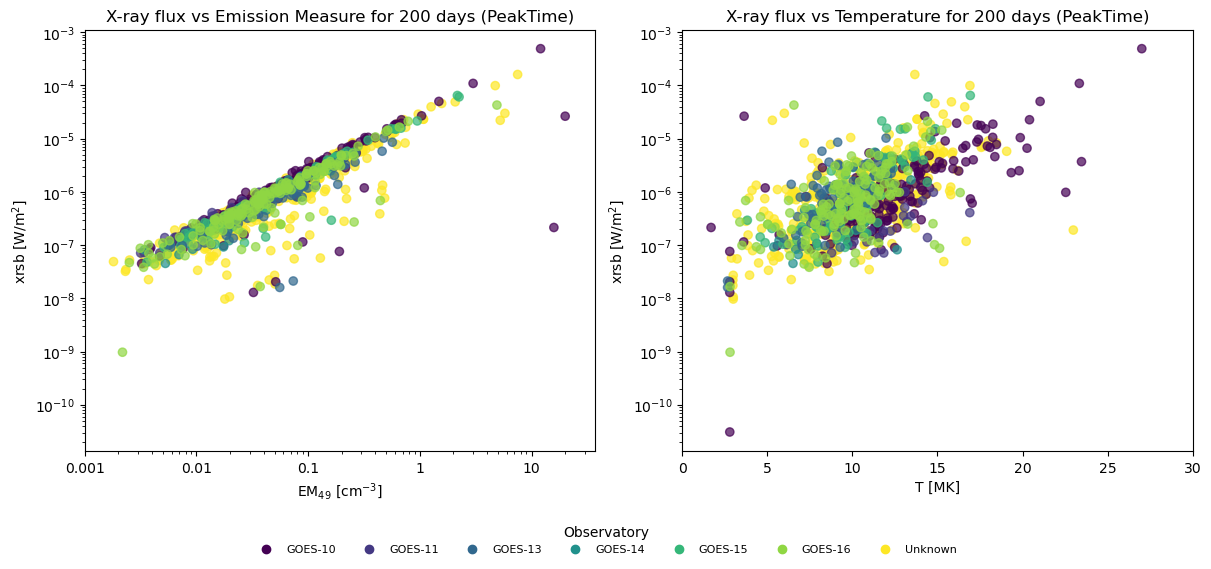

In [18]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Observatory",      # "None" o "Class" o "Date" u "Observatory" # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-28 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:02:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:32:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 20:15:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-17 23:04:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-29 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-30 15:16:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 14:38:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 20:03:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 12:08:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 16:32:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 21:17:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-26 23:26:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-27 04:22:00 no encontrado en da

/tmp/ipykernel_2954/659629380.py:838: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


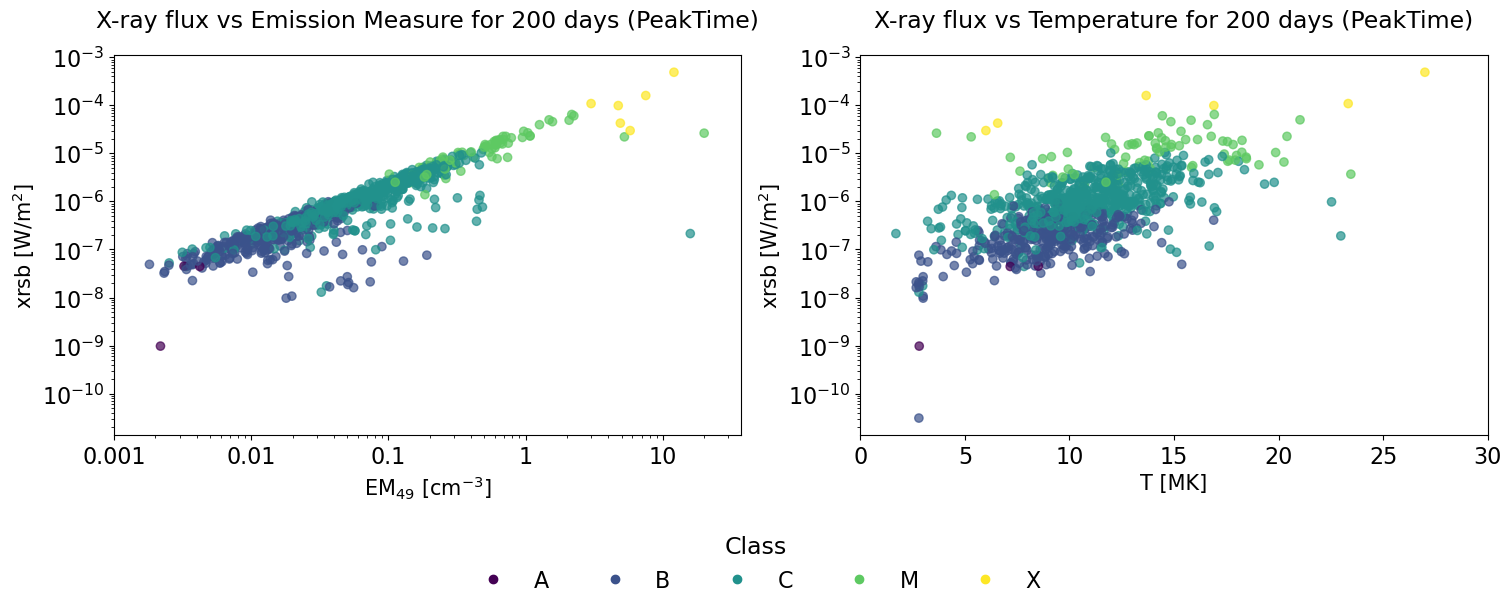

In [164]:
# grafica de características de flares en el peak
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-28 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:02:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:32:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 20:15:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-17 23:04:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-29 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1981-10-30 15:16:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 14:38:00 no encontrado en datos GOES, se salta.
Flare en 1982-01-21 20:03:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 12:08:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 16:32:00 no encontrado en datos GOES, se salta.
Flare en 1982-07-06 21:17:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-26 23:26:00 no encontrado en datos GOES, se salta.
Flare en 1982-09-27 04:22:00 no encontrado en da

/tmp/ipykernel_2954/853623683.py:816: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


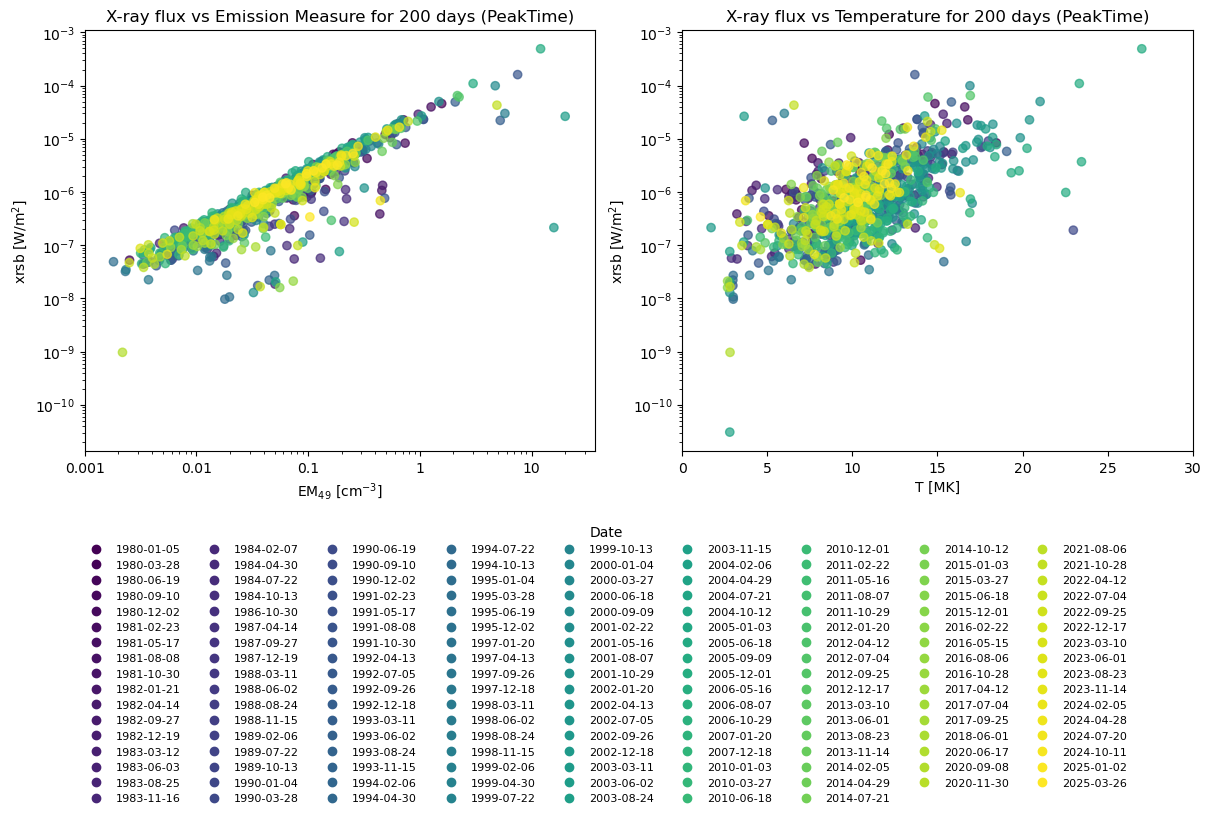

In [20]:

plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Date",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 15:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-05 17:46:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-05 18:56:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-19 01:53:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-19 06:01:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-19 18:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-19 23:34:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 06:48:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 07:29:00 no encontrado en datos GOES, se salta.
Flare en 1980-09-10 21:48:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 07:36:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 08:06:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 10:42:00 no encontrado en datos GOES, se salta.
Flare en 1980-12-02 20:08:00 no encontrado en datos GOES, se salta.
Flare en 1981-02-23 11:27:00 no encontrado en da

/tmp/ipykernel_2954/853623683.py:816: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


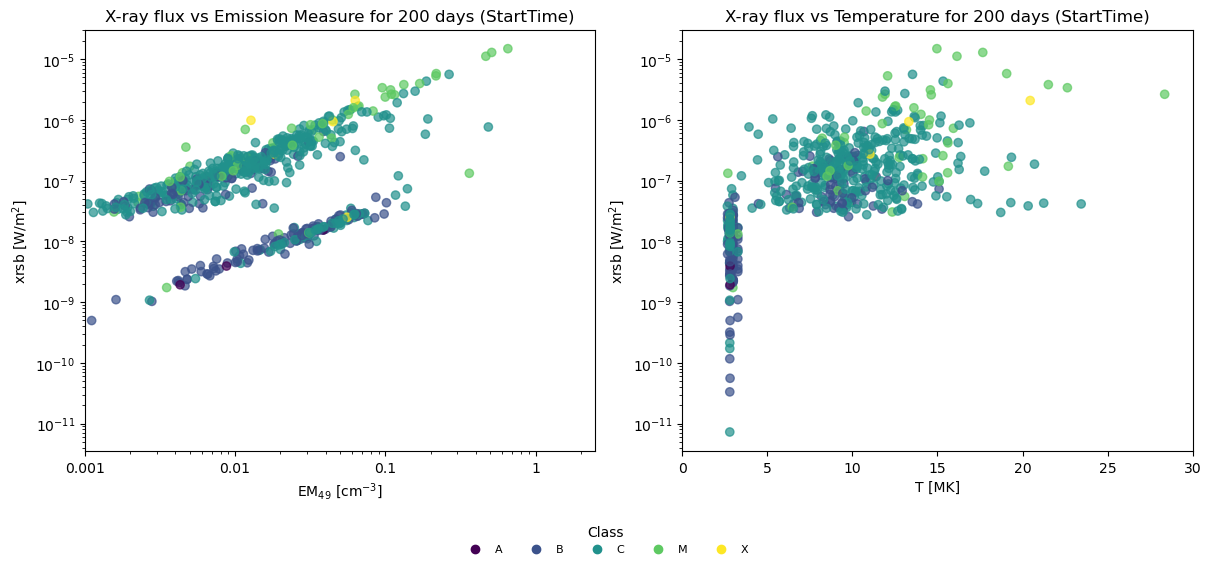

In [21]:
# grafica de características de flares en el peak
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="StartTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

## Analysis FAI 

### Flare with FAI before

/tmp/ipykernel_2954/2734950470.py:610: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


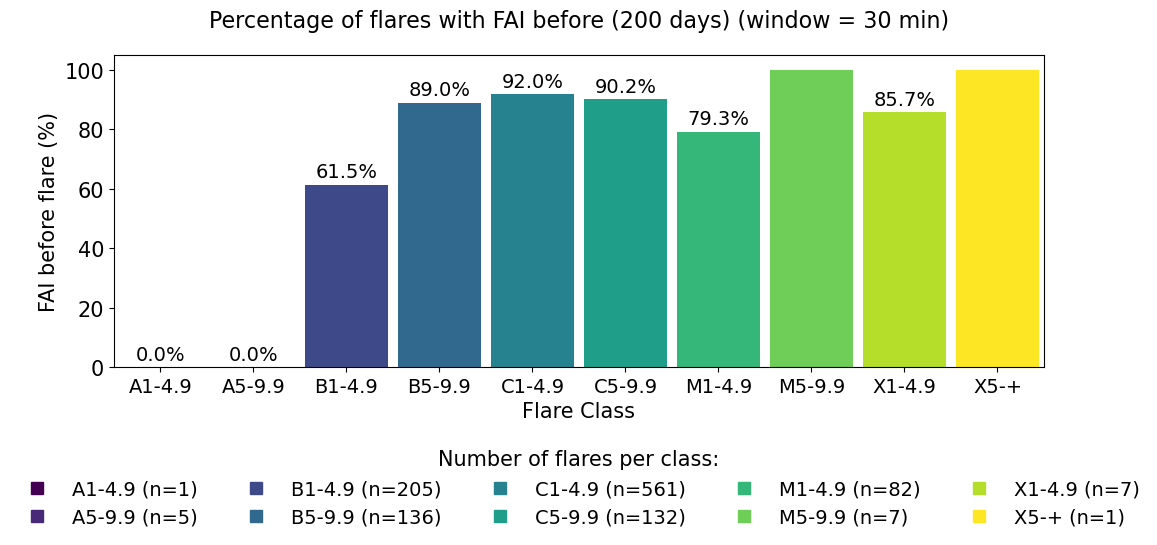

In [128]:
plot_flare_summary_from_csv2(csv_fai_before=csv_fai_before,
                                n_days=n,
                                window_minutes=window_minutes,
                                group_subclasses=True,
                                color_mode="palette:viridis")



/tmp/ipykernel_2954/853623683.py:610: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


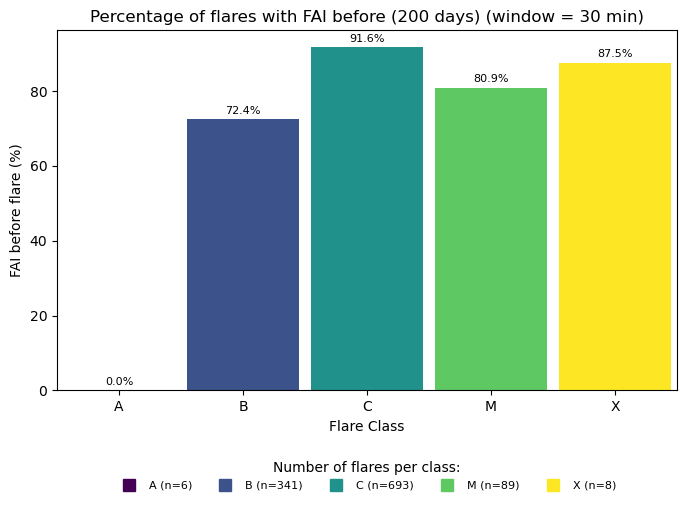

In [23]:
plot_flare_summary_from_csv2(csv_fai_before=csv_fai_before,
                                n_days=n,
                                window_minutes=window_minutes,
                                group_subclasses=False,
                                color_mode="palette:viridis")

### total flares with FAIs

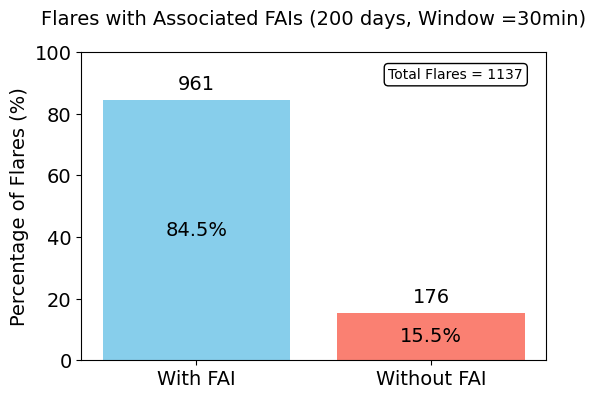

In [72]:
plot_fai_association(csv_fai_before=csv_fai_before, n=n, fai_column="FAI_before_flare")

### FAIs que están asociados a Flares

In [25]:
df_fai_assoc = associate_fai_to_flare(csv_fai_selected=csv_fai_selected,
                                        csv_flares=csv_flares,
                                        window_minutes=window_minutes,
                                        time_ref='PeakTime'
                                    )
df_fai_assoc.to_csv(os.path.join(analysis_dir, "df_fai_assoc.csv"))

In [26]:
df_fai_assoc

,Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_StartTime,Flare_EndTime,Flare_PeakTime,Flare_Class,Time_to_flare
0,1980-01-05 00:13:00,Unknown,2.171900e-08,0.000002,7.478500e-09,1.702001e-07,7.404709,1.419828e+47,6.444598,4.887520e+47,0.014198,0.048875,1980-01-05 00:13:00,False,NaT,NaT,NaT,None,None
1,1980-01-05 00:14:00,Unknown,2.218579e-08,0.000002,7.978946e-09,1.800003e-07,7.434225,1.489869e+47,6.471225,5.118306e+47,0.014899,0.051183,1980-01-05 00:14:00,False,NaT,NaT,NaT,None,None
2,1980-01-05 00:15:00,Unknown,2.081550e-08,0.000002,7.781501e-09,1.818001e-07,7.317579,1.552705e+47,6.366079,5.376859e+47,0.015527,0.053769,1980-01-05 00:15:00,False,NaT,NaT,NaT,None,None
3,1980-01-05 00:16:00,Unknown,1.939105e-08,0.000002,6.772209e-09,1.667369e-07,7.147209,1.493902e+47,6.212901,5.234078e+47,0.014939,0.052341,1980-01-05 00:16:00,False,NaT,NaT,NaT,None,None
4,1980-01-05 00:45:00,Unknown,2.091579e-08,0.000001,6.412631e-09,9.663154e-08,8.966467,5.763681e+46,7.876660,1.788404e+47,0.005764,0.017884,1980-01-05 00:45:00,False,NaT,NaT,NaT,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16156,2025-03-26 23:21:00,GOES-16,1.260876e-07,0.000002,8.933740e-08,5.709040e-07,12.245831,2.433984e+47,11.267645,6.016661e+47,0.024340,0.060167,2025-03-26 23:21:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,3.0
16157,2025-03-26 23:22:00,GOES-16,1.542042e-07,0.000002,1.121657e-07,7.442413e-07,12.039510,3.228154e+47,11.039608,8.086210e+47,0.032282,0.080862,2025-03-26 23:22:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,2.0
16158,2025-03-26 23:23:00,GOES-16,1.601581e-07,0.000002,1.184432e-07,8.427995e-07,11.663001,3.780250e+47,10.629533,9.703740e+47,0.037802,0.097037,2025-03-26 23:23:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,1.0
16159,2025-03-26 23:24:00,GOES-16,1.480383e-07,0.000002,9.516748e-08,8.001058e-07,10.798725,3.922800e+47,9.726554,1.063228e+48,0.039228,0.106323,2025-03-26 23:24:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,0.0


In [27]:
# Filtrar solo las FAIs asociadas a un flare
df_fai_with_flare = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True]

df_fai_with_flare

,Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_StartTime,Flare_EndTime,Flare_PeakTime,Flare_Class,Time_to_flare
103,1980-01-05 15:05:00,Unknown,4.184450e-08,0.000002,2.885000e-08,2.592000e-07,11.440485,1.119124e+47,10.344282,2.956234e+47,0.011191,0.029562,1980-01-05 15:05:00,True,1980-01-05 15:10:00,1980-01-05 15:47:00,1980-01-05 15:32:00,C9.0,27.0
104,1980-01-05 15:06:00,Unknown,3.854421e-08,0.000002,2.586137e-08,3.012630e-07,10.135790,1.507479e+47,8.996251,4.341833e+47,0.015075,0.043418,1980-01-05 15:06:00,True,1980-01-05 15:10:00,1980-01-05 15:47:00,1980-01-05 15:32:00,C9.0,26.0
105,1980-01-05 15:07:00,Unknown,3.547100e-08,0.000002,2.464980e-08,3.258000e-07,9.543546,1.771247e+47,8.421849,5.297078e+47,0.017712,0.052971,1980-01-05 15:07:00,True,1980-01-05 15:10:00,1980-01-05 15:47:00,1980-01-05 15:32:00,C9.0,25.0
106,1980-01-05 15:08:00,Unknown,3.407790e-08,0.000002,2.139474e-08,2.974735e-07,9.315839,1.674916e+47,8.205315,5.081995e+47,0.016749,0.050820,1980-01-05 15:08:00,True,1980-01-05 15:10:00,1980-01-05 15:47:00,1980-01-05 15:32:00,C9.0,24.0
107,1980-01-05 15:13:00,Unknown,8.466263e-08,0.000002,5.058473e-08,5.375263e-07,10.585282,2.544013e+47,9.446602,7.116229e+47,0.025440,0.071162,1980-01-05 15:13:00,True,1980-01-05 15:10:00,1980-01-05 15:47:00,1980-01-05 15:32:00,C9.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16155,2025-03-26 23:20:00,GOES-16,9.402007e-08,0.000002,6.292512e-08,4.138209e-07,12.088114,1.787552e+47,11.093131,4.463632e+47,0.017876,0.044636,2025-03-26 23:20:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,4.0
16156,2025-03-26 23:21:00,GOES-16,1.260876e-07,0.000002,8.933740e-08,5.709040e-07,12.245831,2.433984e+47,11.267645,6.016661e+47,0.024340,0.060167,2025-03-26 23:21:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,3.0
16157,2025-03-26 23:22:00,GOES-16,1.542042e-07,0.000002,1.121657e-07,7.442413e-07,12.039510,3.228154e+47,11.039608,8.086210e+47,0.032282,0.080862,2025-03-26 23:22:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,2.0
16158,2025-03-26 23:23:00,GOES-16,1.601581e-07,0.000002,1.184432e-07,8.427995e-07,11.663001,3.780250e+47,10.629533,9.703740e+47,0.037802,0.097037,2025-03-26 23:23:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,1.0


In [28]:
df_fai_assoc.to_csv(os.path.join(analysis_dir, "df_fai_assoc.csv"))

In [29]:
df_fai_with_flare.iloc[574:]

,Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_StartTime,Flare_EndTime,Flare_PeakTime,Flare_Class,Time_to_flare
1745,1982-07-06 21:01:00,Unknown,9.081801e-08,0.000001,7.717006e-09,1.077499e-07,9.297207,6.084750e+46,8.187688,1.848414e+47,0.006085,0.018484,1982-07-06 21:01:00,True,1982-07-06 21:05:00,1982-07-06 21:36:00,1982-07-06 21:17:00,C1.3,16.0
1746,1982-07-06 21:02:00,Unknown,9.302950e-08,0.000001,1.127750e-08,1.140501e-07,10.833568,5.245927e+46,9.701325,1.443619e+47,0.005246,0.014436,1982-07-06 21:02:00,True,1982-07-06 21:05:00,1982-07-06 21:36:00,1982-07-06 21:17:00,C1.3,15.0
1747,1982-07-06 21:03:00,Unknown,9.142300e-08,0.000001,7.117492e-09,9.685004e-08,9.412050,5.371774e+46,8.296550,1.619948e+47,0.005372,0.016199,1982-07-06 21:03:00,True,1982-07-06 21:05:00,1982-07-06 21:36:00,1982-07-06 21:17:00,C1.3,14.0
1748,1982-07-06 21:04:00,Unknown,9.011600e-08,0.000001,3.798505e-09,9.164989e-08,7.212316,8.060162e+46,6.271378,2.811380e+47,0.008060,0.028114,1982-07-06 21:04:00,True,1982-07-06 21:05:00,1982-07-06 21:36:00,1982-07-06 21:17:00,C1.3,13.0
1749,1982-07-06 21:05:00,Unknown,9.194600e-08,0.000001,5.026997e-09,9.225005e-08,8.173415,6.406237e+46,7.143311,2.093560e+47,0.006406,0.020936,1982-07-06 21:05:00,True,1982-07-06 21:05:00,1982-07-06 21:36:00,1982-07-06 21:17:00,C1.3,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16155,2025-03-26 23:20:00,GOES-16,9.402007e-08,0.000002,6.292512e-08,4.138209e-07,12.088114,1.787552e+47,11.093131,4.463632e+47,0.017876,0.044636,2025-03-26 23:20:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,4.0
16156,2025-03-26 23:21:00,GOES-16,1.260876e-07,0.000002,8.933740e-08,5.709040e-07,12.245831,2.433984e+47,11.267645,6.016661e+47,0.024340,0.060167,2025-03-26 23:21:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,3.0
16157,2025-03-26 23:22:00,GOES-16,1.542042e-07,0.000002,1.121657e-07,7.442413e-07,12.039510,3.228154e+47,11.039608,8.086210e+47,0.032282,0.080862,2025-03-26 23:22:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,2.0
16158,2025-03-26 23:23:00,GOES-16,1.601581e-07,0.000002,1.184432e-07,8.427995e-07,11.663001,3.780250e+47,10.629533,9.703740e+47,0.037802,0.097037,2025-03-26 23:23:00,True,2025-03-26 23:15:00,2025-03-26 23:35:00,2025-03-26 23:24:00,C2.4,1.0


In [30]:
'''
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2025-08-16 18:00:00",
    flare_end_time="2025-08-16 21:10:00", 
    ymin=1e-8, ymax=1e-5)
    
'''

'\nplot_fai_and_flare_lines(\n    df_combined=df_full,\n    df_fai_selected=df_fai_selected,\n    df_flare_data=df_flare_data,\n    flare_start_time="2025-08-16 18:00:00",\n    flare_end_time="2025-08-16 21:10:00", \n    ymin=1e-8, ymax=1e-5)\n\n'

### Graphs FAIs

In [31]:
# archivo df_fai_assoc fai con flare asociado
# ,Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,
# Time_FAI,Associated_Flare,Flare_StartTime,Flare_EndTime,Flare_PeakTime,Flare_Class,Time_to_flare
csv_fai_assoc= os.path.join(analysis_dir, "df_fai_assoc.csv")

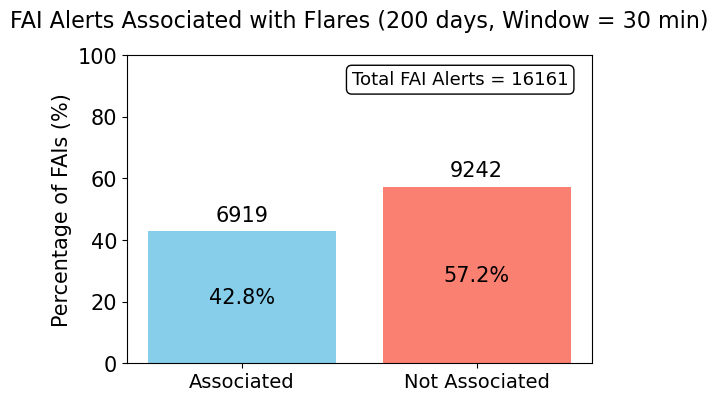

In [125]:
plot_fai_association_summary(csv_fai_assoc=csv_fai_assoc, window = window_minutes, column="Associated_Flare")

/tmp/ipykernel_2954/4130276179.py:1158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


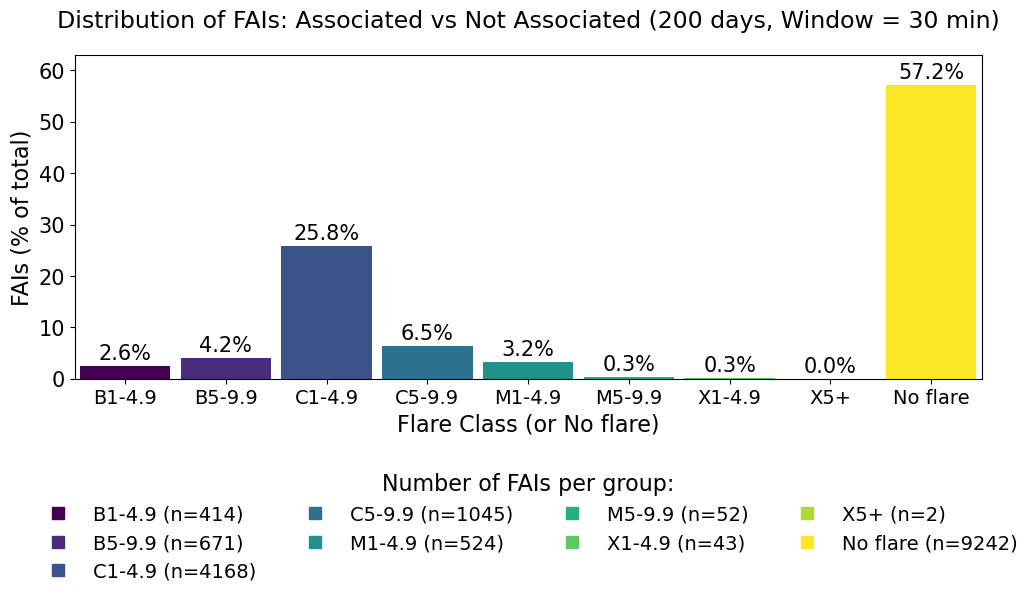

In [153]:
# Usar rangos C1–4.9, C5–9.9, X5+ y paleta viridis
plot_fai_distribution(csv_fai_assoc, window = window_minutes, group_subclasses=True, color_mode="palette:viridis")

/tmp/ipykernel_2954/853623683.py:1135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


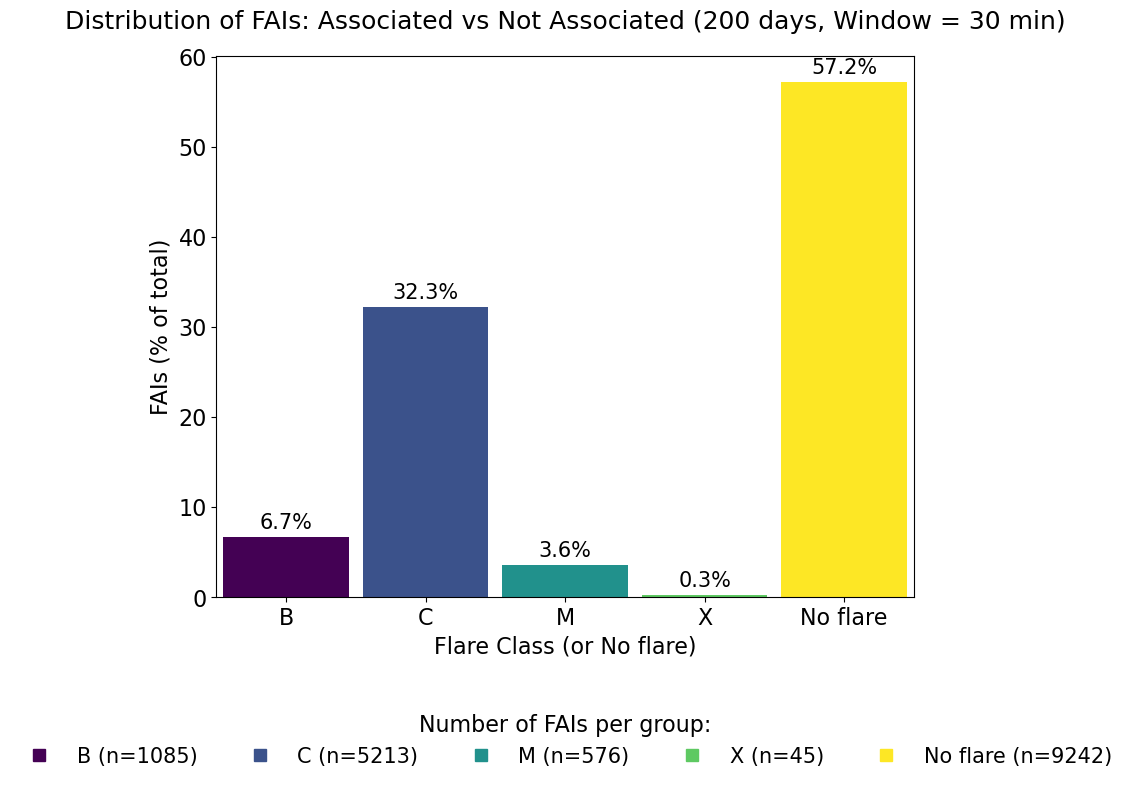

In [34]:
# Usar clases, X5+ y paleta viridis
plot_fai_distribution(csv_fai_assoc, window = window_minutes, group_subclasses=False, color_mode="palette:viridis")

### por clases

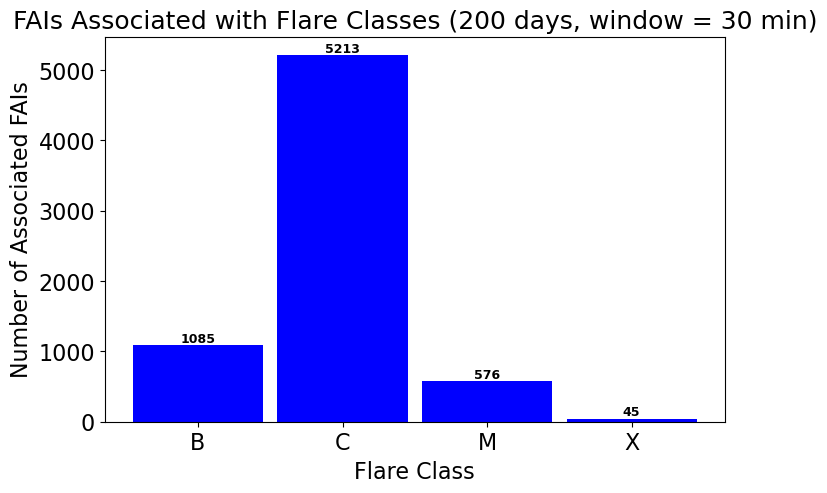

In [35]:
# Por letra
# Color único
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="letter", color_mode="single:blue")


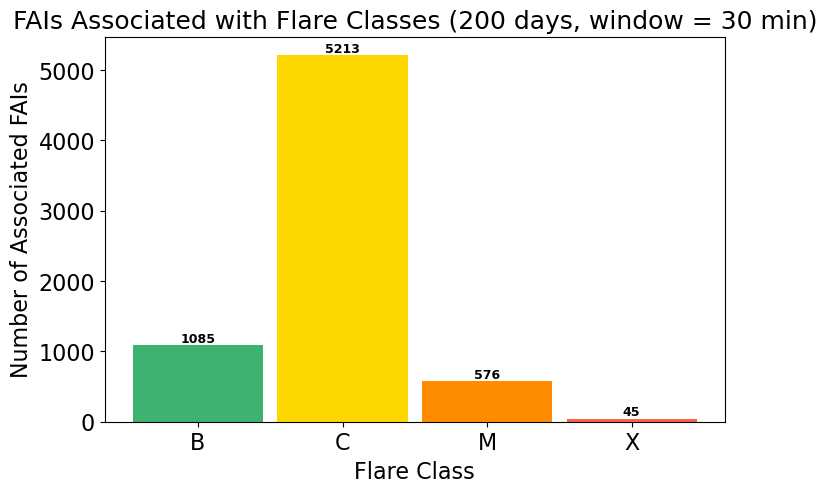

In [36]:
# Colores por clase
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="letter", color_mode="by_class")

/tmp/ipykernel_2954/853623683.py:1289: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


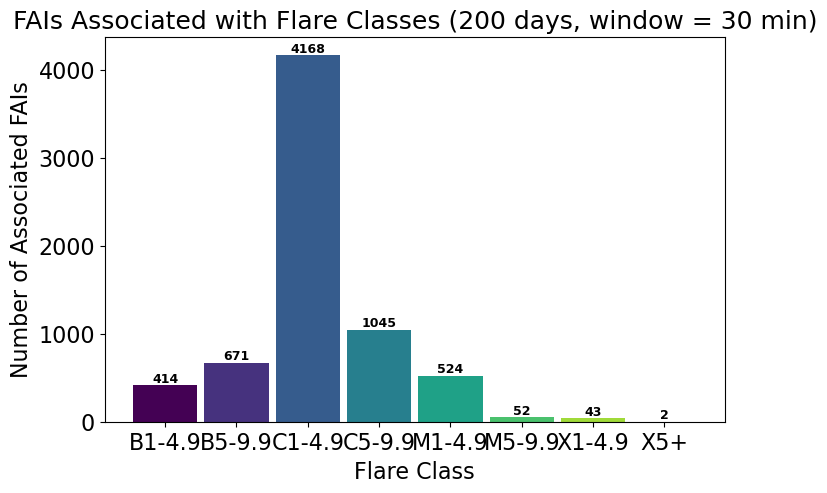

In [37]:

# Por rangos (usa los group_ranges definidos dentro de la función)
# Paleta viridis
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="range", color_mode="palette:viridis")

### por porcentaje ( aun no sé cómo)

In [38]:
def plot_fai_assoc_percent_by_class(csv_fai_assoc,
                                    class_col="Flare_Class",
                                    assoc_col="Associated_Flare",
                                    group_subclasses=False,
                                    color_mode="palette:viridis"):
    """
    Plots percentage of FAIs associated with flares per class.
    
    Parameters:
    - csv_fai_assoc: path to CSV with FAIs and flare association
    - class_col: column with flare class (default "Flare_Class")
    - assoc_col: column with True/False for association (default "Associated_Flare")
    - group_subclasses: False = use exact classes, True = use grouped ranges
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Ranges for grouping
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 = infinito → X5+
    }

    # Load CSV
    df = pd.read_csv(csv_fai_assoc)

    # Make sure columns exist
    if class_col not in df.columns or assoc_col not in df.columns:
        raise ValueError(f"CSV must contain '{class_col}' and '{assoc_col}' columns.")

    # Function to assign group range
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class

        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                if letter == "X" and high >= 1000:
                    return f"{letter}{low}+"
                else:
                    return f"{letter}{low}-{high}"
        return flare_class

    # Apply grouping
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(assign_flare_group)
    else:
        df["ClassGroup"] = df[class_col]

    # Calculate percentages
    summary = df.groupby("ClassGroup")[assoc_col].mean() * 100
    counts = df.groupby("ClassGroup")[assoc_col].count()

    classes = summary.index.tolist()
    values = summary.tolist()
    n_bars = len(classes)

    # Colors
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # Plot
    chart_width = max(8, n_bars * 0.55)
    chart_height = 6
    fig, ax = plt.subplots(figsize=(chart_width, chart_height))

    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("FAI associated with flare (%)")
    ax.set_xlabel("Flare Class")
    ax.set_title("Percentage of FAIs associated per flare class")

    # Add percentages on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=8)

    # Legend
    legend_labels = [f"{cls} (n={counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]
    ax.legend(handles=handles, loc="upper right", fontsize=8, frameon=False)

    plt.show()

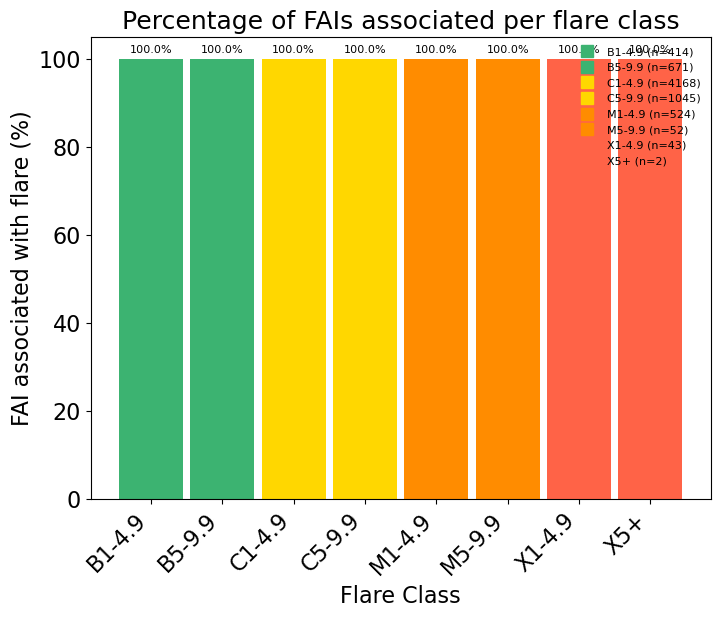

In [39]:
plot_fai_assoc_percent_by_class(
    csv_fai_assoc=csv_fai_assoc, 
    class_col="Flare_Class", 
    assoc_col="Associated_Flare",
    group_subclasses=True,      # activa rangos C1–4.9, C5–9.9, X5+ etc.
    color_mode="by_class"       # colores fijos por clase A/B/C/M/X
)


### otros

In [40]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time = anticipation_time.sort_values(by="Anticipation (min)", ascending=False)

df_sorted_anticipation_time.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min),observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
556,12,2001-08-07 13:30:00,2001-08-07 13:43:00,C3.5,GOES,2001-08-07 13:35:00,30.0,2001-08-07 13:05:00,32.0,GOES-10,2.884609e-07,3.935799e-06,6.444218e-08,4.812252e-07,13.928576,1.890777e+47,13.278597,4.206127e+47,0.018908,0.042061
616,0,2002-12-18 02:21:00,2002-12-18 02:27:00,C3.5,GOES,2002-12-18 02:25:00,29.0,2002-12-18 01:56:00,NaN,GOES-10,9.415409e-08,2.843350e-06,1.354961e-08,1.224121e-07,12.835008,5.162434e+46,11.977601,1.228681e+47,0.005162,0.012287
549,5,2001-08-07 07:26:00,2001-08-07 07:47:00,M1.1,GOES,2001-08-07 07:37:00,28.0,2001-08-07 07:09:00,56.0,GOES-10,4.761270e-08,1.784798e-06,1.690430e-08,1.310273e-07,13.706777,5.216310e+46,13.012235,1.175530e+47,0.005216,0.011755
596,2,2002-07-05 07:56:00,2002-07-05 08:20:00,C7.8,GOES,2002-07-05 08:09:00,28.0,2002-07-05 07:41:00,30.0,GOES-10,3.501733e-07,3.744212e-06,5.450843e-08,1.300383e-06,8.199062,9.942571e+47,7.199699,3.208096e+48,0.099426,0.320810
676,3,2005-06-18 02:23:00,2005-06-18 02:31:00,B4.2,GOES,2005-06-18 02:27:00,27.0,2005-06-18 02:00:00,29.0,GOES-10,4.745036e-08,7.485222e-07,1.458339e-08,2.762951e-07,9.140108,1.767772e+47,8.076302,5.367885e+47,0.017678,0.053679
126,12,1983-06-03 23:35:00,1983-06-04 00:03:00,C2.0,GOES,1983-06-03 23:43:00,27.0,1983-06-03 23:16:00,NaN,Unknown,1.411400e-08,1.129450e-06,2.114001e-09,6.979997e-08,7.323813,6.310534e+46,6.369824,2.185881e+47,0.006311,0.021859
239,3,1989-10-13 05:00:00,1989-10-13 08:30:00,M4.1,GOES,1989-10-13 06:12:00,26.0,1989-10-13 05:46:00,NaN,Unknown,4.636000e-06,2.932500e-05,4.542353e-07,3.783824e-06,12.535177,1.906937e+48,11.573894,4.678399e+48,0.190694,0.467840
714,6,2005-12-01 12:44:00,2005-12-01 12:50:00,B9.8,GOES,2005-12-01 12:48:00,26.0,2005-12-01 12:22:00,27.0,GOES-10,1.662173e-07,2.317279e-06,1.573403e-08,4.963857e-07,7.211541,4.847191e+47,6.299912,1.670569e+48,0.048472,0.167057
457,14,1995-03-28 22:09:00,1995-03-28 22:15:00,B1.6,GOES,1995-03-28 22:13:00,25.0,1995-03-28 21:48:00,27.0,Unknown,9.428630e-09,3.039147e-07,6.375655e-09,1.822994e-07,7.480041,1.694601e+47,6.511735,5.799876e+47,0.016946,0.057999
209,2,1989-02-06 02:13:00,1989-02-06 02:33:00,M1.1,GOES,1989-02-06 02:15:00,24.0,1989-02-06 01:51:00,25.0,Unknown,2.267000e-07,3.411500e-06,8.089502e-08,8.305001e-07,11.450163,4.588913e+47,10.354559,1.212707e+48,0.045889,0.121271


In [41]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time = anticipation_time.sort_values(by="Anticipation (min)", ascending=True)

df_sorted_anticipation_time.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min),observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
983,9,2021-10-28 18:07:00,2021-10-28 18:14:00,C3.1,GOES,2021-10-28 18:10:00,1.0,2021-10-28 18:09:00,NaN,GOES-16,1.265563e-07,2.374955e-06,2.135597e-08,1.673061e-07,11.158759,7.886689e+46,10.096284,2.090465e+47,0.007887,0.020905
543,9,2001-05-16 23:44:00,2001-05-16 23:56:00,C2.3,GOES,2001-05-16 23:49:00,1.0,2001-05-16 23:48:00,NaN,GOES-10,1.990350e-07,3.326926e-06,1.273270e-07,1.308620e-06,12.136663,5.830086e+47,11.170566,1.453554e+48,0.058301,0.145355
583,0,2002-01-20 15:43:00,2002-01-20 16:06:00,C3.8,GOES,2002-01-20 15:52:00,1.0,2002-01-20 15:51:00,NaN,GOES-10,4.367395e-07,5.469365e-06,1.926702e-07,2.000084e-06,12.083526,8.951234e+47,11.110193,2.239777e+48,0.089512,0.223978
577,9,2001-10-29 17:32:00,2001-10-29 17:49:00,C2.6,GOES,2001-10-29 17:39:00,1.0,2001-10-29 17:38:00,NaN,GOES-10,2.594600e-07,3.721362e-06,2.117588e-07,1.713763e-06,13.455119,6.930146e+47,12.711642,1.585478e+48,0.069301,0.158548
882,6,2014-02-05 16:11:00,2014-02-05 16:42:00,M1.3,GOES,2014-02-05 16:20:00,1.0,2014-02-05 16:19:00,NaN,GOES-13,2.807562e-06,2.132790e-05,2.220641e-06,1.518225e-05,12.455048,6.743491e+48,11.569709,1.632259e+49,0.674349,1.632259
883,7,2014-02-05 18:32:00,2014-02-05 18:54:00,C8.6,GOES,2014-02-05 18:44:00,1.0,2014-02-05 18:43:00,NaN,GOES-13,1.545645e-06,1.401671e-05,9.390462e-07,7.994369e-06,11.300385,3.952817e+48,10.269903,1.035500e+49,0.395282,1.035500
994,3,2022-04-12 04:17:00,2022-04-12 04:29:00,B6.0,GOES,2022-04-12 04:23:00,1.0,2022-04-12 04:22:00,14.0,GOES-16,3.399383e-08,6.127263e-07,2.011311e-08,2.290359e-07,9.374299,1.358809e+47,8.338075,4.007575e+47,0.013588,0.040076
992,1,2022-04-12 03:40:00,2022-04-12 03:51:00,B5.3,GOES,2022-04-12 03:47:00,1.0,2022-04-12 03:46:00,14.0,GOES-16,2.315156e-08,5.177070e-07,1.176790e-08,1.344853e-07,9.358846,7.998042e+46,8.323494,2.361029e+47,0.007998,0.023610
991,0,2022-04-12 03:26:00,2022-04-12 03:37:00,B8.7,GOES,2022-04-12 03:33:00,1.0,2022-04-12 03:32:00,NaN,GOES-16,4.138598e-08,7.472683e-07,1.919248e-08,2.213070e-07,9.320268,1.324196e+47,8.287127,3.917912e+47,0.013242,0.039179
985,11,2021-10-28 21:02:00,2021-10-28 21:11:00,C1.5,GOES,2021-10-28 21:07:00,1.0,2021-10-28 21:06:00,NaN,GOES-16,8.088023e-08,1.205424e-06,4.094409e-08,2.953017e-07,11.591330,1.333445e+47,10.552547,3.438826e+47,0.013334,0.034388


In [42]:
print(anticipation_time["Anticipation (min)"].min(), anticipation_time["Anticipation (min)"].max())

1.0 30.0


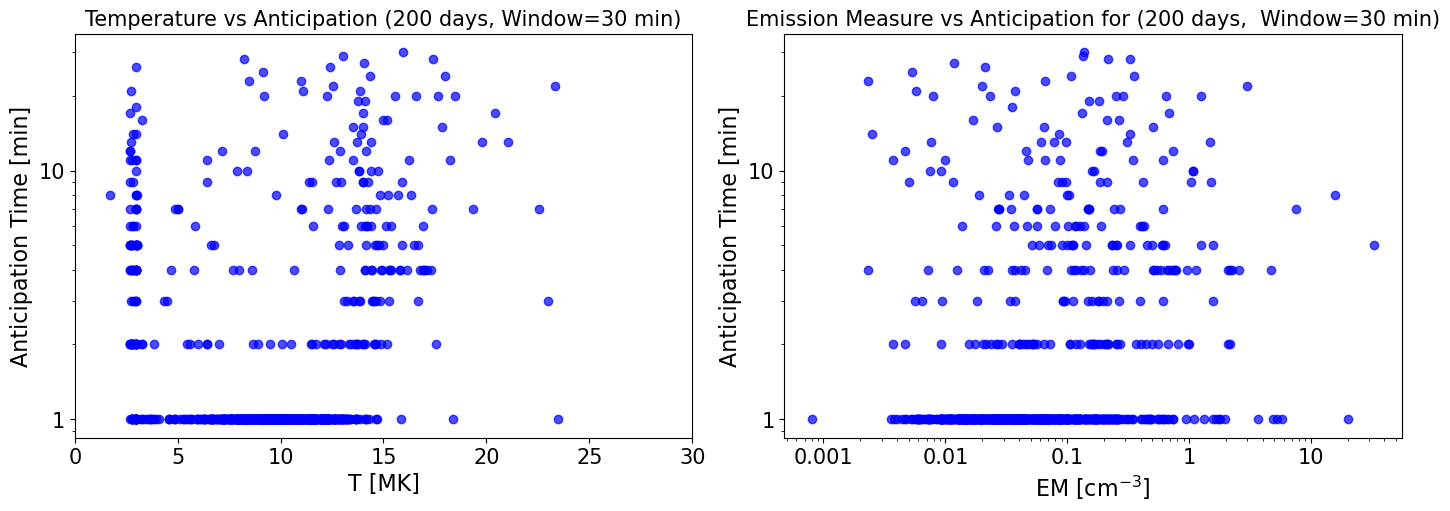

In [43]:
plot_anticipation_vs_te(days=n,
                            max_gap_fai = window_minutes,
                            csv_full=csv_full,
                            csv_flares=csv_flares,
                            csv_anticipation=csv_anticipation_time,
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor_norm",
                            color_by=None,        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None   # dict de colores fijos
                            )


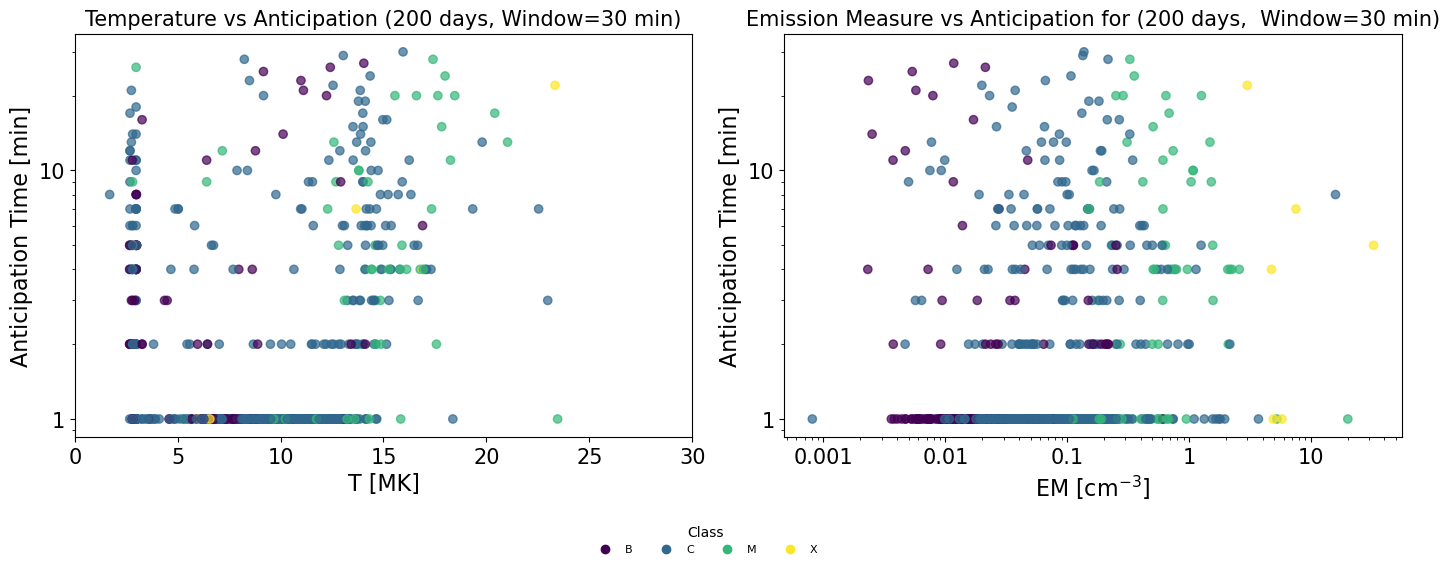

In [44]:
plot_anticipation_vs_te(days=n,
                            max_gap_fai = window_minutes,
                            csv_full=csv_full,
                            csv_flares=csv_flares,
                            csv_anticipation=csv_anticipation_time,
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor_norm",
                            color_by="Class",        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None   # dict de colores fijos
                            )


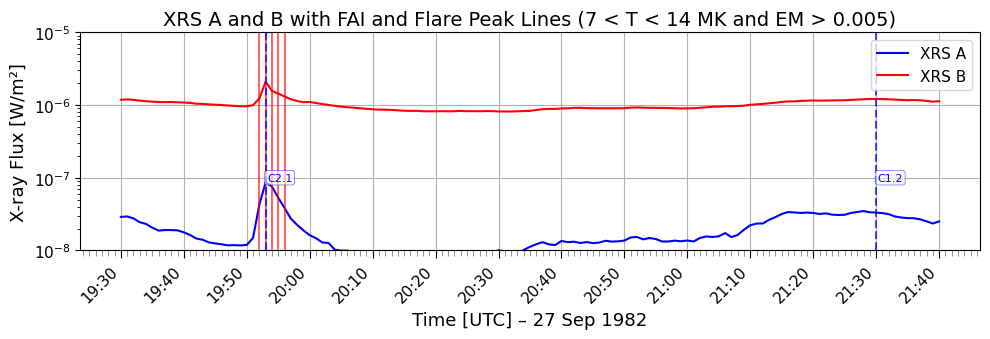

In [45]:

plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="1982-09-27 19:30:00",
    flare_end_time="1982-09-27 21:40:00", 
    ymin=1e-8, ymax=1e-5)



In [46]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time_by_class = anticipation_time.sort_values(by="Class", ascending=False)

df_sorted_anticipation_time_by_class.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min),observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
707,14,2005-09-09 19:13:00,2005-09-09 20:36:00,X6.2,GOES,2005-09-09 20:04:00,5.0,2005-09-09 19:59:00,NaN,GOES-10,3.327367e-04,0.000916,3.752328e-06,7.073226e-05,9.162101,4.508987e+49,8.097093,1.367253e+50,4.508987,13.672526
309,15,1991-10-30 06:11:00,1991-10-30 09:03:00,X2.5,GOES,1991-10-30 06:21:00,7.0,1991-10-30 06:14:00,53.0,Unknown,1.195500e-06,0.000012,1.029206e-06,6.709705e-06,13.902263,3.098145e+48,13.188339,6.969554e+48,0.309815,0.696955
695,2,2005-09-09 02:43:00,2005-09-09 03:07:00,X1.1,GOES,2005-09-09 03:00:00,22.0,2005-09-09 02:38:00,24.0,GOES-10,2.935618e-06,0.000016,3.873183e-07,3.233425e-06,13.277209,1.322696e+48,12.500001,3.059526e+48,0.132270,0.305953
527,0,2000-06-18 01:52:00,2000-06-18 02:03:00,X1.0,GOES,2000-06-18 01:59:00,4.0,2000-06-18 01:55:00,NaN,Unknown,1.537613e-07,0.000002,1.446596e-07,1.225997e-06,12.461104,7.234894e+47,11.502957,1.787717e+48,0.072349,0.178772
488,4,1998-08-24 21:50:00,1998-08-24 22:35:00,X1.0,GOES,1998-08-24 22:12:00,1.0,1998-08-24 22:11:00,NaN,Unknown,1.862914e-05,0.000108,3.447279e-06,4.120335e-05,10.765067,2.833211e+49,9.648485,7.840334e+49,2.833211,7.840334
982,8,2021-10-28 15:17:00,2021-10-28 15:48:00,X1.0,GOES,2021-10-28 15:35:00,1.0,2021-10-28 15:34:00,NaN,GOES-16,1.661530e-05,0.000100,8.007068e-06,6.293287e-05,11.141995,2.971827e+49,10.078877,7.885443e+49,2.971827,7.885443
107,11,1982-12-19 15:41:00,1982-12-19 18:34:00,M9.0,GOES,1982-12-19 16:32:00,20.0,1982-12-19 16:12:00,NaN,Unknown,1.574053e-06,0.000015,2.990527e-07,2.059368e-06,12.869353,7.898160e+47,11.961764,1.892947e+48,0.078982,0.189295
34,7,1980-12-02 11:20:00,1980-12-02 12:12:00,M7.5,GOES,1980-12-02 11:23:00,4.0,1980-12-02 11:19:00,34.0,Unknown,1.079116e-07,0.000002,6.083948e-08,3.799473e-07,13.424569,1.404922e+47,12.617210,3.248732e+47,0.014049,0.032487
394,31,1993-03-11 21:51:00,1993-03-11 22:21:00,M7.3,GOES,1993-03-11 21:58:00,4.0,1993-03-11 21:54:00,NaN,Unknown,3.562884e-07,0.000005,2.505743e-07,1.986199e-06,12.801849,9.819197e+47,11.883689,2.366551e+48,0.098192,0.236655
395,32,1993-03-11 21:52:00,1993-03-11 22:29:00,M7.3,GOES,1993-03-11 22:02:00,1.0,1993-03-11 22:01:00,4.0,Unknown,1.327356e-05,0.000074,5.652921e-06,3.904275e-05,13.567065,1.837670e+49,12.787834,4.217176e+49,1.837670,4.217176


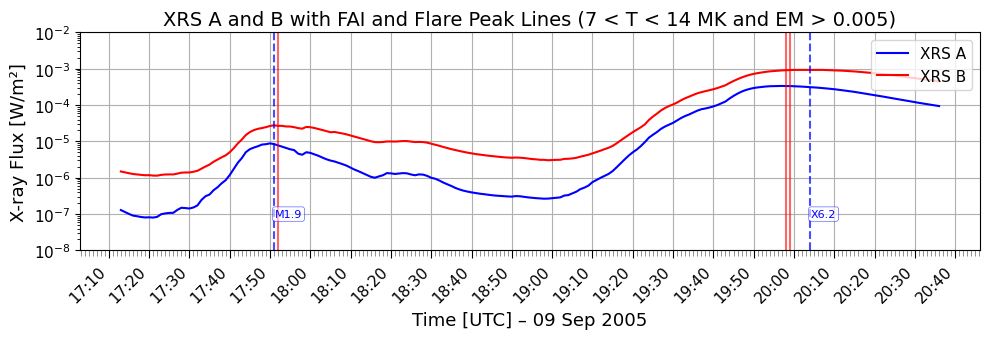

In [47]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2005-09-09 17:13:00",
    flare_end_time="2005-09-09 20:36:00", 
    ymin=1e-8, ymax=1e-2)

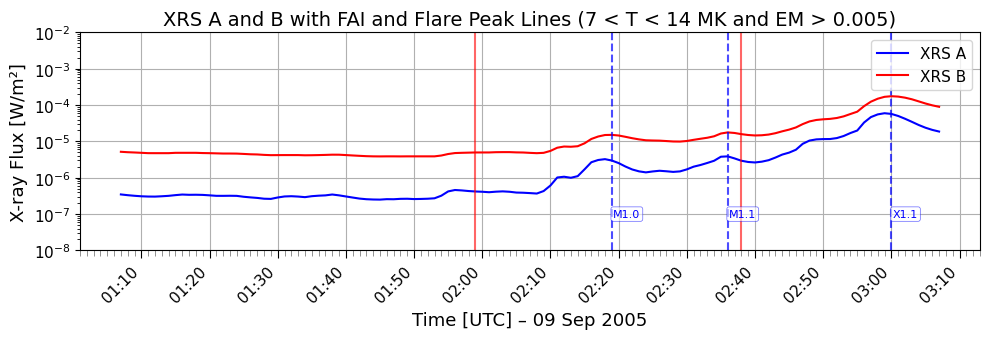

In [48]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2005-09-09 01:07:00",
    flare_end_time="2005-09-09 03:07:00", 
    ymin=1e-8, ymax=1e-2)

In [49]:
# Filtrar primero y luego ordenar
df_sorted_anticipation_time_by_class = (
    anticipation_time[anticipation_time["Anticipation (min)"] > 5]  # filtro
    .sort_values(by="Class", ascending=False)                       # ordenar
)

# Mostrar un rango de filas
df_sorted_anticipation_time_by_class.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min),observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
309,15,1991-10-30 06:11:00,1991-10-30 09:03:00,X2.5,GOES,1991-10-30 06:21:00,7.0,1991-10-30 06:14:00,53.0,Unknown,1.195500e-06,0.000012,1.029206e-06,6.709705e-06,13.902263,3.098145e+48,13.188339,6.969554e+48,0.309815,0.696955
695,2,2005-09-09 02:43:00,2005-09-09 03:07:00,X1.1,GOES,2005-09-09 03:00:00,22.0,2005-09-09 02:38:00,24.0,GOES-10,2.935618e-06,0.000016,3.873183e-07,3.233425e-06,13.277209,1.322696e+48,12.500001,3.059526e+48,0.132270,0.305953
107,11,1982-12-19 15:41:00,1982-12-19 18:34:00,M9.0,GOES,1982-12-19 16:32:00,20.0,1982-12-19 16:12:00,NaN,Unknown,1.574053e-06,0.000015,2.990527e-07,2.059368e-06,12.869353,7.898160e+47,11.961764,1.892947e+48,0.078982,0.189295
44,4,1981-02-23 05:47:00,1981-02-23 06:19:00,M4.4,GOES,1981-02-23 05:54:00,20.0,1981-02-23 05:34:00,NaN,Unknown,8.299951e-08,0.000003,1.829601e-08,1.810497e-07,10.943771,8.226973e+46,9.815937,2.247395e+47,0.008227,0.022474
317,29,1991-10-30 19:13:00,1991-10-30 19:30:00,M4.3,GOES,1991-10-30 19:16:00,10.0,1991-10-30 19:06:00,NaN,Unknown,4.995263e-08,0.000002,6.547367e-09,1.715791e-07,7.478813,1.787941e+47,6.509649,6.128004e+47,0.017879,0.061280
239,3,1989-10-13 05:00:00,1989-10-13 08:30:00,M4.1,GOES,1989-10-13 06:12:00,26.0,1989-10-13 05:46:00,NaN,Unknown,4.636000e-06,0.000029,4.542353e-07,3.783824e-06,12.535177,1.906937e+48,11.573894,4.678399e+48,0.190694,0.467840
637,2,2003-06-02 08:12:00,2003-06-02 08:52:00,M3.9,GOES,2003-06-02 08:37:00,9.0,2003-06-02 08:28:00,NaN,GOES-10,1.246823e-06,0.000008,7.741176e-08,6.571422e-07,13.182474,2.705161e+47,12.387581,6.294880e+47,0.027052,0.062949
572,4,2001-10-29 10:56:00,2001-10-29 11:19:00,M3.6,GOES,2001-10-29 11:13:00,13.0,2001-10-29 11:00:00,NaN,GOES-10,1.425832e-07,0.000003,8.742805e-08,7.549079e-07,13.086695,3.127849e+47,12.274152,7.323279e+47,0.031278,0.073233
284,3,1991-05-17 09:03:00,1991-05-17 10:19:00,M3.3,GOES,1991-05-17 09:04:00,20.0,1991-05-17 08:44:00,NaN,Unknown,3.682632e-08,0.000002,5.352636e-09,1.100000e-07,8.334092,9.424643e+46,7.289146,3.049498e+47,0.009425,0.030495
598,4,2002-07-05 13:10:00,2002-07-05 13:37:00,M3.2,GOES,2002-07-05 13:26:00,17.0,2002-07-05 13:09:00,NaN,GOES-10,3.132214e-08,0.000001,6.344331e-09,1.120650e-07,9.449704,6.821508e+46,8.370635,2.031081e+47,0.006822,0.020311


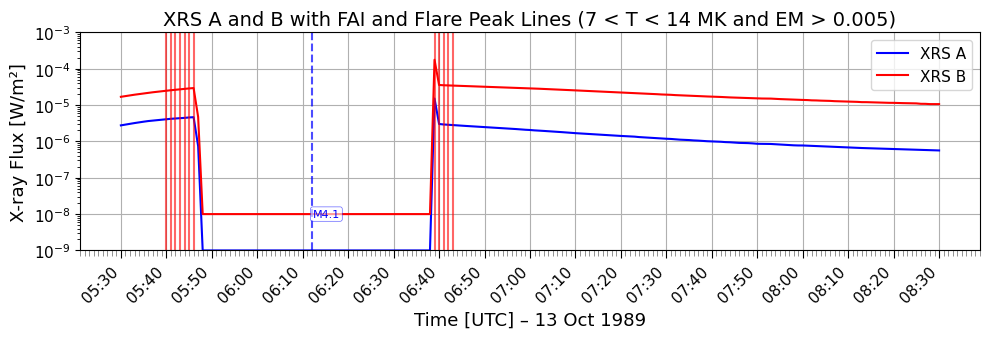

In [50]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="1989-10-13 05:30:00",
    flare_end_time="1989-10-13 08:30:00", 
    ymin=1e-9, ymax=1e-3)

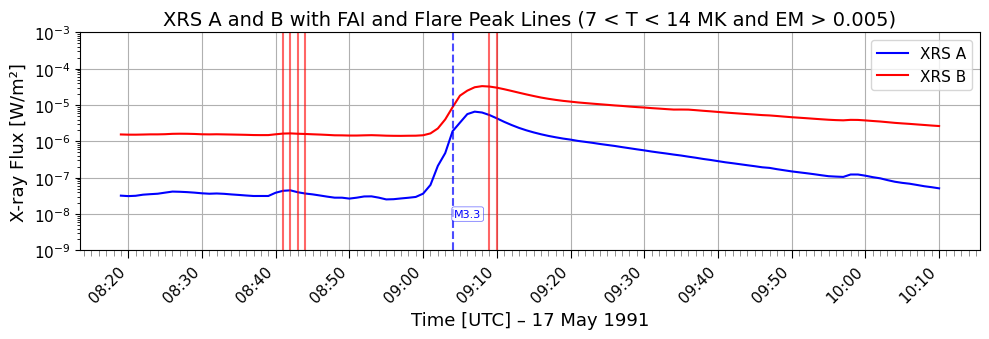

In [51]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="1991-05-17 08:19:00",
    flare_end_time="1991-05-17 10:10:00", 
    ymin=1e-9, ymax=1e-3)

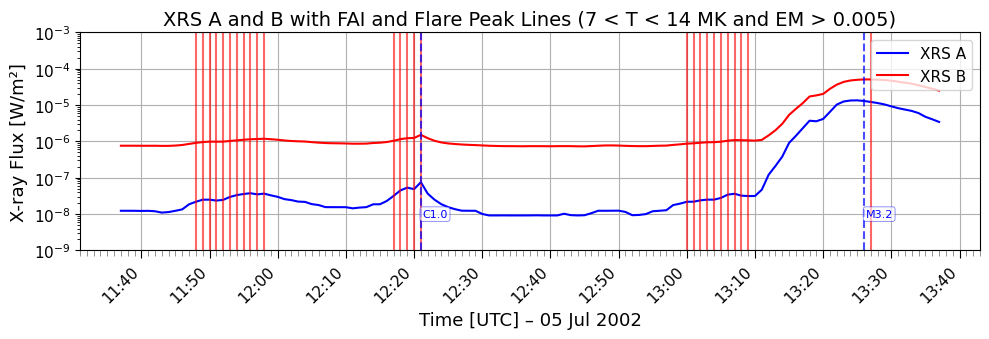

In [52]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2002-07-05 11:37:00",
    flare_end_time="2002-07-05 13:37:00", 
    ymin=1e-9, ymax=1e-3)

In [53]:
df_flare_fai_before

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,FAI_before_flare,FAI_first_time,FAI_last_time,FAI_count
0,0,1980-01-05 15:10:00,1980-01-05 15:47:00,C9.0,GOES,1980-01-05 15:32:00,True,1980-01-05 15:05:00,1980-01-05 15:26:00,14
1,1,1980-01-05 17:46:00,1980-01-05 18:29:00,C3.0,GOES,1980-01-05 18:18:00,True,1980-01-05 17:56:00,1980-01-05 18:01:00,6
2,2,1980-01-05 18:56:00,1980-01-05 19:29:00,C4.0,GOES,1980-01-05 19:17:00,True,1980-01-05 19:13:00,1980-01-05 19:16:00,4
3,0,1980-03-28 03:03:00,1980-03-28 03:25:00,C1.0,GOES,1980-03-28 03:06:00,False,NaT,NaT,0
4,1,1980-03-28 03:40:00,1980-03-28 03:52:00,C2.0,GOES,1980-03-28 03:43:00,True,1980-03-28 03:21:00,1980-03-28 03:42:00,7
...,...,...,...,...,...,...,...,...,...,...
1132,4,2025-03-26 11:49:00,2025-03-26 12:02:00,C2.8,GOES,2025-03-26 11:54:00,True,2025-03-26 11:24:00,2025-03-26 11:53:00,10
1133,5,2025-03-26 13:24:00,2025-03-26 13:50:00,C2.7,GOES,2025-03-26 13:37:00,True,2025-03-26 13:19:00,2025-03-26 13:36:00,13
1134,6,2025-03-26 19:10:00,2025-03-26 19:31:00,C7.0,GOES,2025-03-26 19:23:00,True,2025-03-26 18:54:00,2025-03-26 19:22:00,21
1135,7,2025-03-26 20:35:00,2025-03-26 20:46:00,C1.9,GOES,2025-03-26 20:42:00,True,2025-03-26 20:40:00,2025-03-26 20:41:00,2


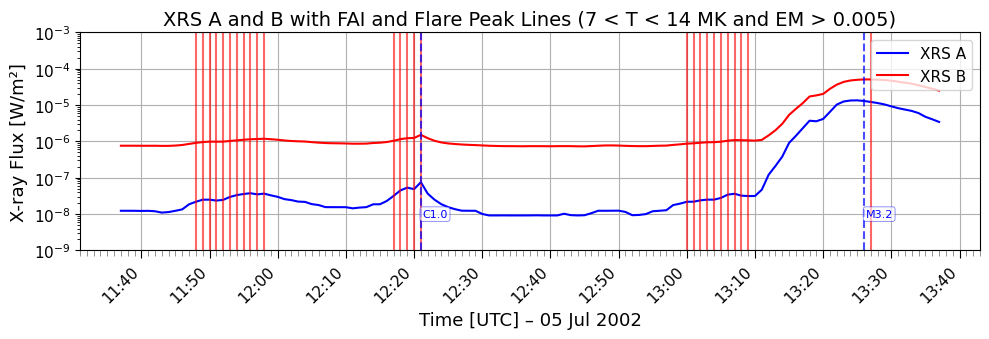

In [54]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2002-07-05 11:37:00",
    flare_end_time="2002-07-05 13:37:00", 
    ymin=1e-9, ymax=1e-3)

In [55]:
# Filtrar primero y luego ordenar
df_sorted_flare_fai_before = (
    df_flare_fai_before[df_flare_fai_before["FAI_count"] > 5]  # filtro
    .sort_values(by="Class", ascending=False)                       # ordenar
)

# Mostrar un rango de filas
df_sorted_flare_fai_before.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,FAI_before_flare,FAI_first_time,FAI_last_time,FAI_count
309,15,1991-10-30 06:11:00,1991-10-30 09:03:00,X2.5,GOES,1991-10-30 06:21:00,True,1991-10-30 06:06:00,1991-10-30 06:14:00,7
488,4,1998-08-24 21:50:00,1998-08-24 22:35:00,X1.0,GOES,1998-08-24 22:12:00,True,1998-08-24 21:42:00,1998-08-24 22:11:00,21
982,8,2021-10-28 15:17:00,2021-10-28 15:48:00,X1.0,GOES,2021-10-28 15:35:00,True,2021-10-28 15:21:00,2021-10-28 15:34:00,11
107,11,1982-12-19 15:41:00,1982-12-19 18:34:00,M9.0,GOES,1982-12-19 16:32:00,True,1982-12-19 16:02:00,1982-12-19 16:12:00,11
34,7,1980-12-02 11:20:00,1980-12-02 12:12:00,M7.5,GOES,1980-12-02 11:23:00,True,1980-12-02 11:08:00,1980-12-02 11:19:00,8
394,31,1993-03-11 21:51:00,1993-03-11 22:21:00,M7.3,GOES,1993-03-11 21:58:00,True,1993-03-11 21:28:00,1993-03-11 21:54:00,14
817,4,2012-07-04 09:47:00,2012-07-04 09:57:00,M5.3,GOES,2012-07-04 09:55:00,True,2012-07-04 09:26:00,2012-07-04 09:51:00,13
828,15,2012-07-04 22:03:00,2012-07-04 22:15:00,M4.6,GOES,2012-07-04 22:09:00,True,2012-07-04 21:39:00,2012-07-04 22:05:00,10
317,29,1991-10-30 19:13:00,1991-10-30 19:30:00,M4.3,GOES,1991-10-30 19:16:00,True,1991-10-30 18:51:00,1991-10-30 19:06:00,8
598,4,2002-07-05 13:10:00,2002-07-05 13:37:00,M3.2,GOES,2002-07-05 13:26:00,True,2002-07-05 13:00:00,2002-07-05 13:09:00,10


In [56]:
df_sorted_flare_fai_before = (
    df_flare_fai_before[
        (df_flare_fai_before["FAI_count"] > 5) &
        (df_flare_fai_before["Class"].str.startswith(("M", "X"))) &
        (df_flare_fai_before["StartTime"] > "2024-01-01 00:00:01")
    ]
    .sort_values(by="Class", ascending=False)
)

df_sorted_flare_fai_before.iloc[:10]

,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,FAI_before_flare,FAI_first_time,FAI_last_time,FAI_count
1089,3,2024-02-05 04:13:00,2024-02-05 04:44:00,M2.1,GOES,2024-02-05 04:28:00,True,2024-02-05 03:59:00,2024-02-05 04:24:00,17
1122,6,2024-10-11 16:07:00,2024-10-11 16:46:00,M2.1,GOES,2024-10-11 16:33:00,True,2024-10-11 16:04:00,2024-10-11 16:24:00,16
1112,6,2024-07-20 18:36:00,2024-07-20 19:02:00,M1.5,GOES,2024-07-20 18:49:00,True,2024-07-20 18:21:00,2024-07-20 18:48:00,21
1090,4,2024-02-05 06:10:00,2024-02-05 06:26:00,M1.4,GOES,2024-02-05 06:22:00,True,2024-02-05 06:13:00,2024-02-05 06:21:00,9
1121,5,2024-10-11 15:48:00,2024-10-11 16:07:00,M1.4,GOES,2024-10-11 16:04:00,True,2024-10-11 15:39:00,2024-10-11 16:03:00,15
1127,3,2025-01-02 17:18:00,2025-01-02 17:59:00,M1.1,GOES,2025-01-02 17:40:00,True,2025-01-02 17:14:00,2025-01-02 17:39:00,26
1130,2,2025-03-26 07:44:00,2025-03-26 08:21:00,M1.0,GOES,2025-03-26 08:09:00,True,2025-03-26 07:41:00,2025-03-26 08:08:00,26


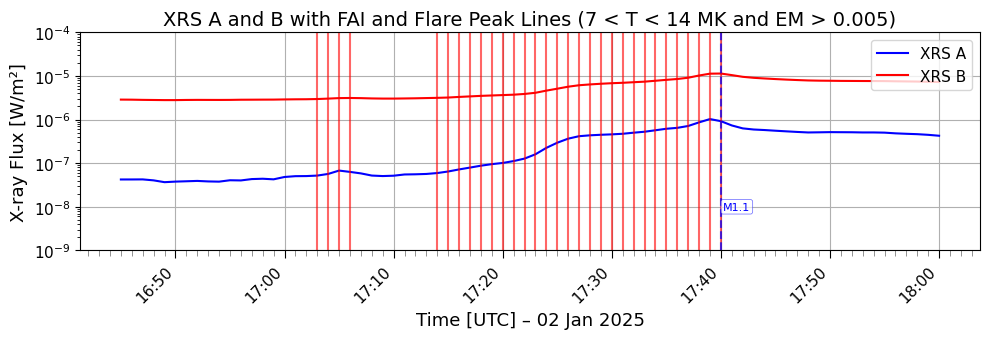

In [57]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2025-01-02 16:45:00",
    flare_end_time="2025-01-02 18:00:00", 
    ymin=1e-9, ymax=1e-4)

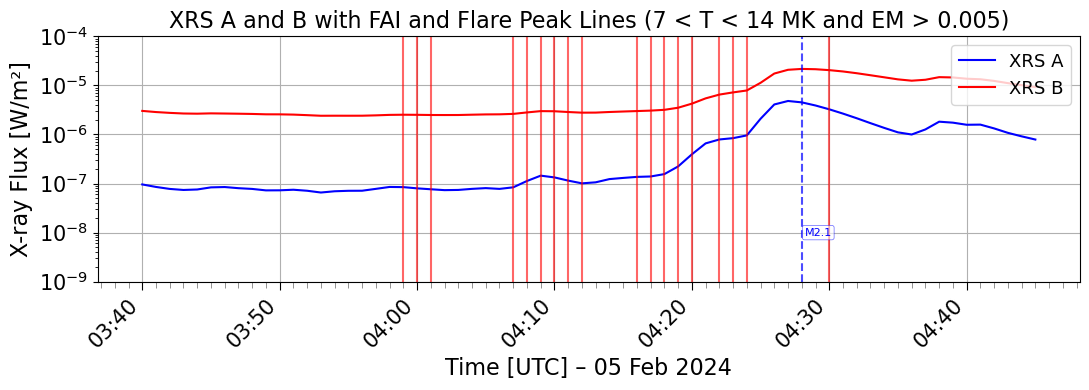

In [64]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2024-02-05 03:40:00",
    flare_end_time="2024-02-05 04:45:00", 
    ymin=1e-9, ymax=1e-4)